# Volcanic Impact in Obs

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import geoxarray
from geoplots import mapplot
import xlearn
from climindex import get_climate_index
from geoplots import xticksmonth

!date
%matplotlib notebook

Wed Jan  9 16:58:16 EST 2019


In [2]:
das = dict()
ncfile = '/tigress/wenchang/data/cru/cru_ts4.01.1901.2016.pre.dat.nc'
data_name = 'pre'

In [40]:
ds = xr.open_dataset(ncfile)
da = ds[data_name]
# anomaly from clim
da_clim = da.groupby('time.month').mean('time')
da = da.groupby('time.month') - da_clim
da = da.resample(time='MS').mean('time')



In [44]:
da

<xarray.DataArray 'pre' (time: 1392, lat: 360, lon: 720)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 1901-03-01 ...
  * lon      (lon) float32 -179.75 -179.25 -178.75 -178.25 -177.75 -177.25 ...
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...

In [43]:
nino34 = open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.Indices/.nino/.EXTENDED/.NINO34/dods') \
    .NINO34 \
    .rename({'T': 'time'}) \
    .sel(time=slice('1901', '2016')) \
    .resample(time='MS').mean('time')
    
nino34

[decode_times=False]: times is decoded externally.


<xarray.DataArray 'NINO34' (time: 1392)>
array([ 0.6677  ,  0.32725 ,  0.0377  , ..., -0.539678, -0.298363, -0.231083])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 1901-03-01 ...

<IPython.core.display.Javascript object>


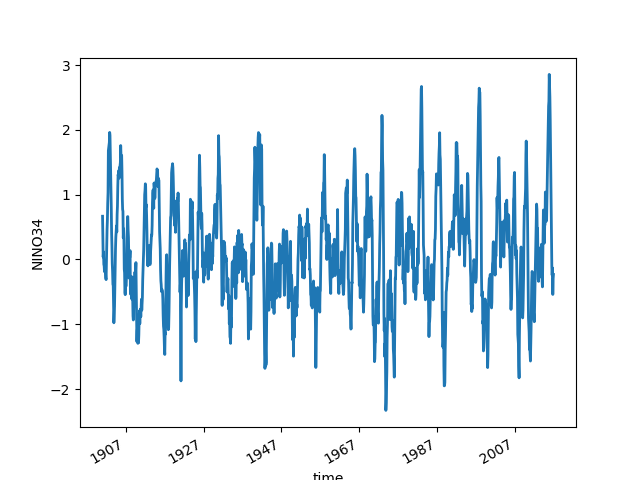

In [48]:
nino34.plot()

In [45]:
r = da.learn.regress(nino34)
da_res = da - r.coef_da * nino34
da_res

//home/wenchang/wython/xlearn/linear_model.py:129: RuntimeWarning: divide by zero encountered in true_divide
  t = self.coef_ / se
//home/wenchang/wython/xlearn/linear_model.py:129: RuntimeWarning: invalid value encountered in true_divide
  t = self.coef_ / se
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


<xarray.DataArray (time: 1392, lat: 360, lon: 720)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 1901-03-01 ...
  * lon      (lon) float32 -179.75 -179.25 -178.75 -178.25 -177.75 -177.25 ...
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
    feature  int64 0

In [49]:
def cal_asym_index(da, year_erupt):
    years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
    years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
    
    da_ref = da.sel(time=years_before).groupby('time.month').mean('time')
    daa = da.sel(time=years_after).groupby('time.month') - da_ref # anomaly
    daa_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
    daa_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
    daa_global = daa.geo.fldmean().mean('time')
    return (daa_nh - daa_sh)/daa_global

In [58]:
volcs = ('StMaria', 'Novarupta', 'Agung', 'ElChichon', 'Pinatubo')
years = (1902, 1912, 1963, 1982, 1991)
for volc, year in zip(volcs, years):
    print(volc, cal_asym_index(da, year).item())

StMaria -40.56457536543652
Novarupta -4.274636189320848
Agung -1.9823655754076348
ElChichon -0.0985487771599582
Pinatubo -3.2574013550904466


In [57]:
volcs = ('StMaria', 'Novarupta', 'Agung', 'ElChichon', 'Pinatubo')
years = (1902, 1912, 1963, 1982, 1991)
for volc, year in zip(volcs, years):
    print(volc, cal_asym_index(da_res, year).item())

StMaria 2.6062335174987368
Novarupta -0.18494046881903858
Agung -2.090723586542266
ElChichon 0.20964275981623604
Pinatubo -6.0731409370994625


## Regression: global rainfall and Nino34

In [31]:
nino = xr.DataArray.from_series(get_climate_index('nino34')) \
    .rename({'index': 'time'}) \
    .resample(time='MS').mean('time')
nino1901_2016 = nino.sel(time=slice('1901', '2016'))

In [32]:
betas = [] # regression coef on NINO34 in each month
months = range(1,13)
for m in months:
    da_ = da[da['time.month']==m]
    nino_ = nino1901_2016[nino1901_2016['time.month']==m]
    r =da_.learn.regress(nino_)
    betas.append(r.coef_da )
b = xr.concat(betas, dim='month').assign_coords(month=months)

//home/wenchang/wython/xlearn/linear_model.py:129: RuntimeWarning: invalid value encountered in true_divide
  t = self.coef_ / se
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
//home/wenchang/wython/xlearn/linear_model.py:129: RuntimeWarning: invalid value encountered in true_divide
  t = self.coef_ / se
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) 

In [33]:
def get_enso_prcp(da, years):
    '''calculate enso-related prcp over specified years given the raw prcp data da'''
    _da = da.sel(time=years)
    _nino = nino1901_2016.sel(time=years)
    
    _das = []
    for m in range(1,13):
        da_m = _da[_da['time.month']==m]
        nino_m = _nino[_nino['time.month']==m]
        _das.append(b.sel(month=m) * nino_m)
    
    return xr.concat(_das, dim='month').max(dim='month')
        

## Agung 1963

In [6]:
# raw data
year_erupt = 1963
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [14]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(-1.982366)

In [15]:
# raw data
year_erupt = 1982
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [16]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(-0.098549)

In [17]:
# raw data
year_erupt = 1991
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [18]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(-3.257401)

In [19]:
# raw data
year_erupt = 1902
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [20]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(-40.564575)

### Seasonal mean

In [108]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean # anomaly
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1,None)) # seasonal meanb

In [107]:
# enso prcp
da_enso = get_enso_prcp(da, years=years_all)
damean = da_enso.sel(time=years_before).groupby('time.month').mean('time')
daa_enso = da_enso.sel(time=years_after).groupby('time.month') - damean # anomaly
daa_enso = daa_enso.resample(time='QS-Dec').mean('time').isel(time=slice(1,None)) # seasonal meanb

<IPython.core.display.Javascript object>


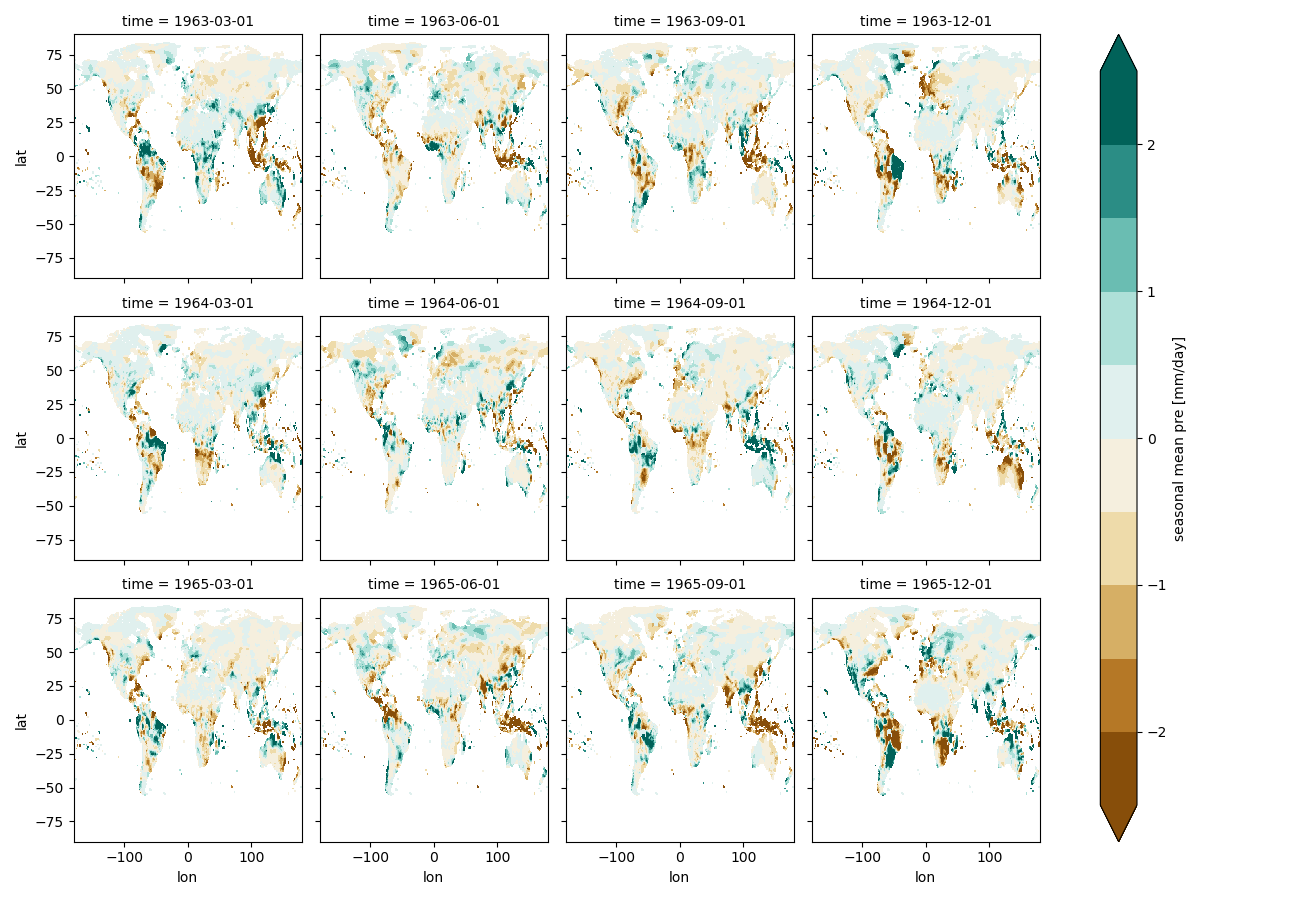

In [109]:
daa.pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


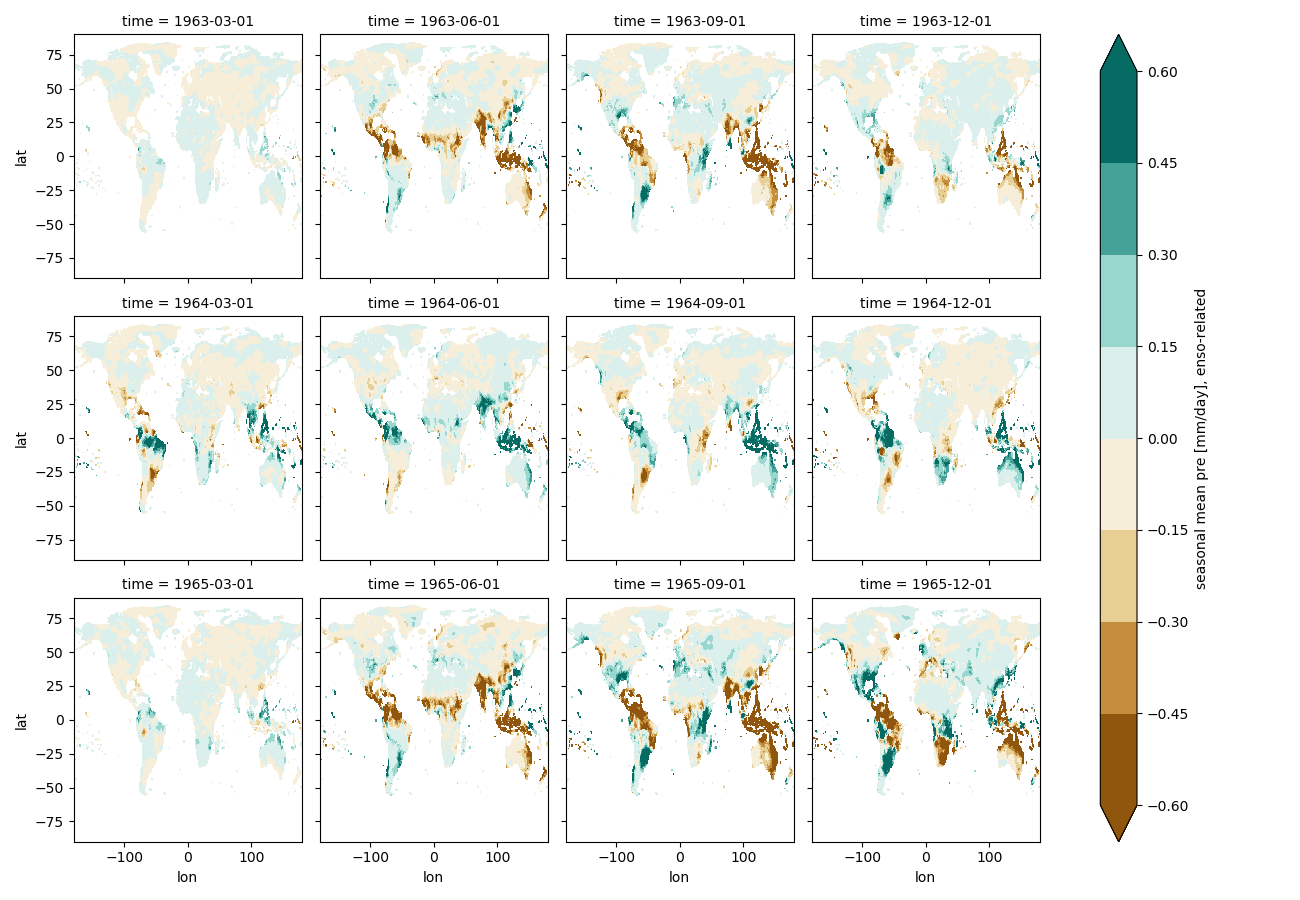

In [118]:
# enso prcp
daa_enso.pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}], enso-related')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


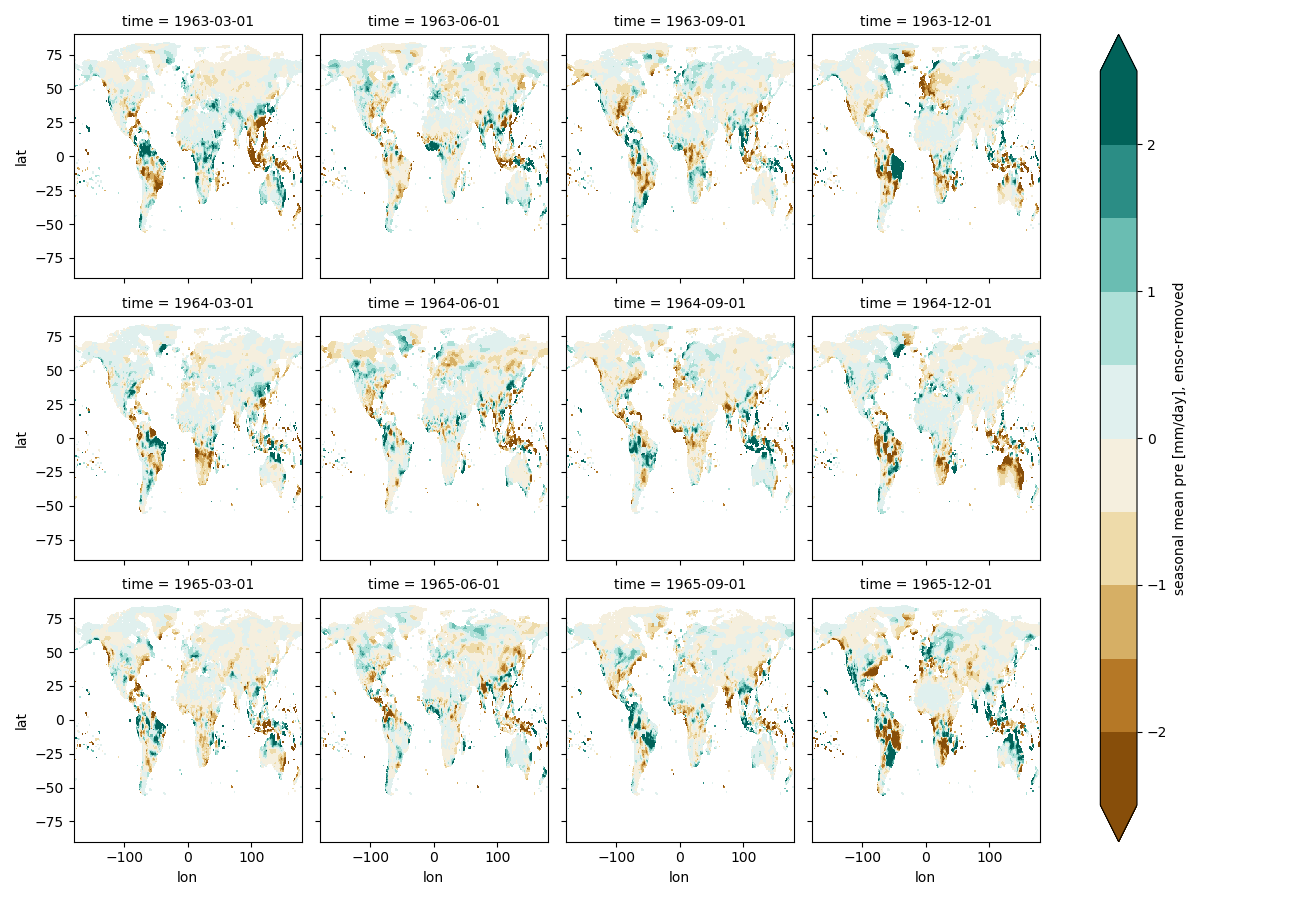

In [119]:
# enso removed
(daa - daa_enso).pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}], enso-removed')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


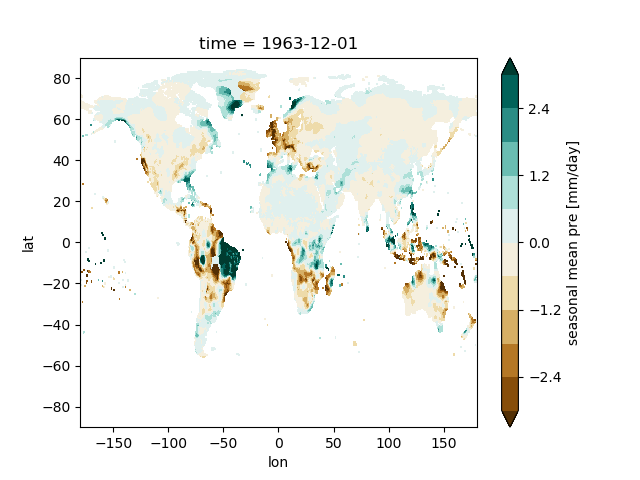

In [112]:
# following winter
daa.sel(time=f'{year_erupt}-12').pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


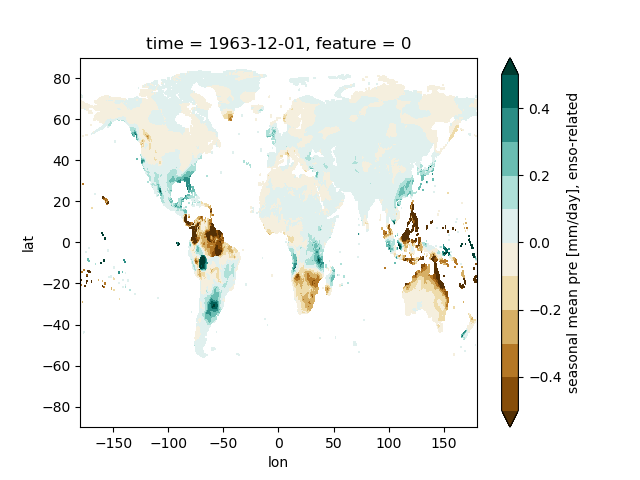

In [120]:
# following winter, enso-related
daa_enso.sel(time=f'{year_erupt}-12').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-related')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


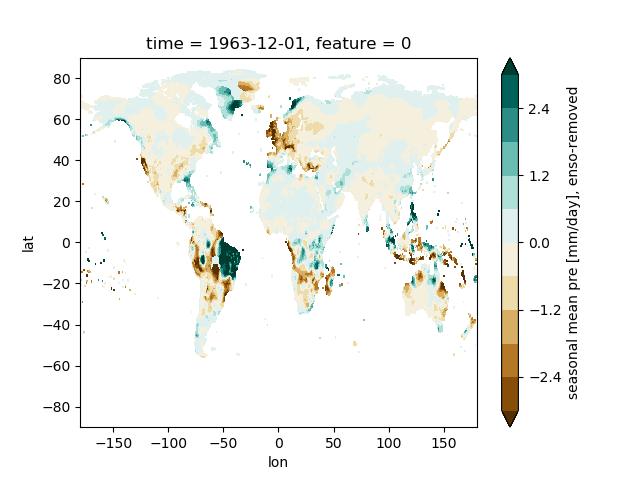

In [121]:
# following winter, enso-removed
(daa - daa_enso).sel(time=f'{year_erupt}-12').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-removed')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


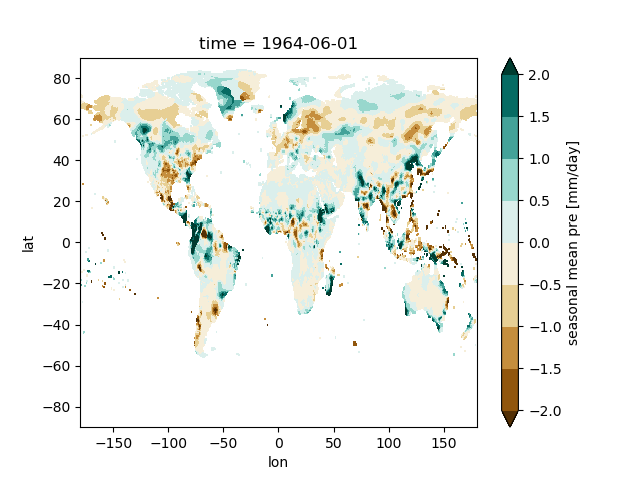

In [115]:
# next-year summer
daa.sel(time=f'{year_erupt+1}-06').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}]')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


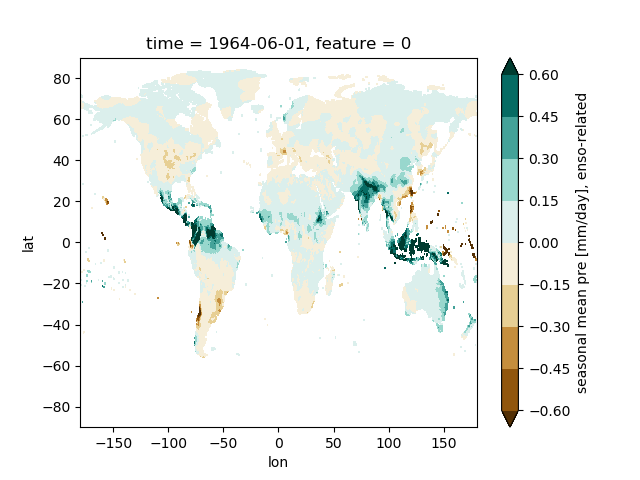

In [122]:
# next-year summer, enso-related
daa_enso.sel(time=f'{year_erupt+1}-06').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-related')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


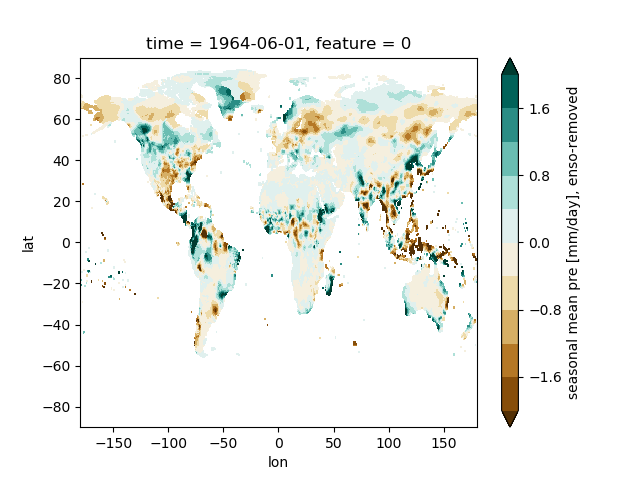

In [124]:
# next-year summer, enso-removed
(daa - daa_enso).sel(time=f'{year_erupt+1}-06').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-removed')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


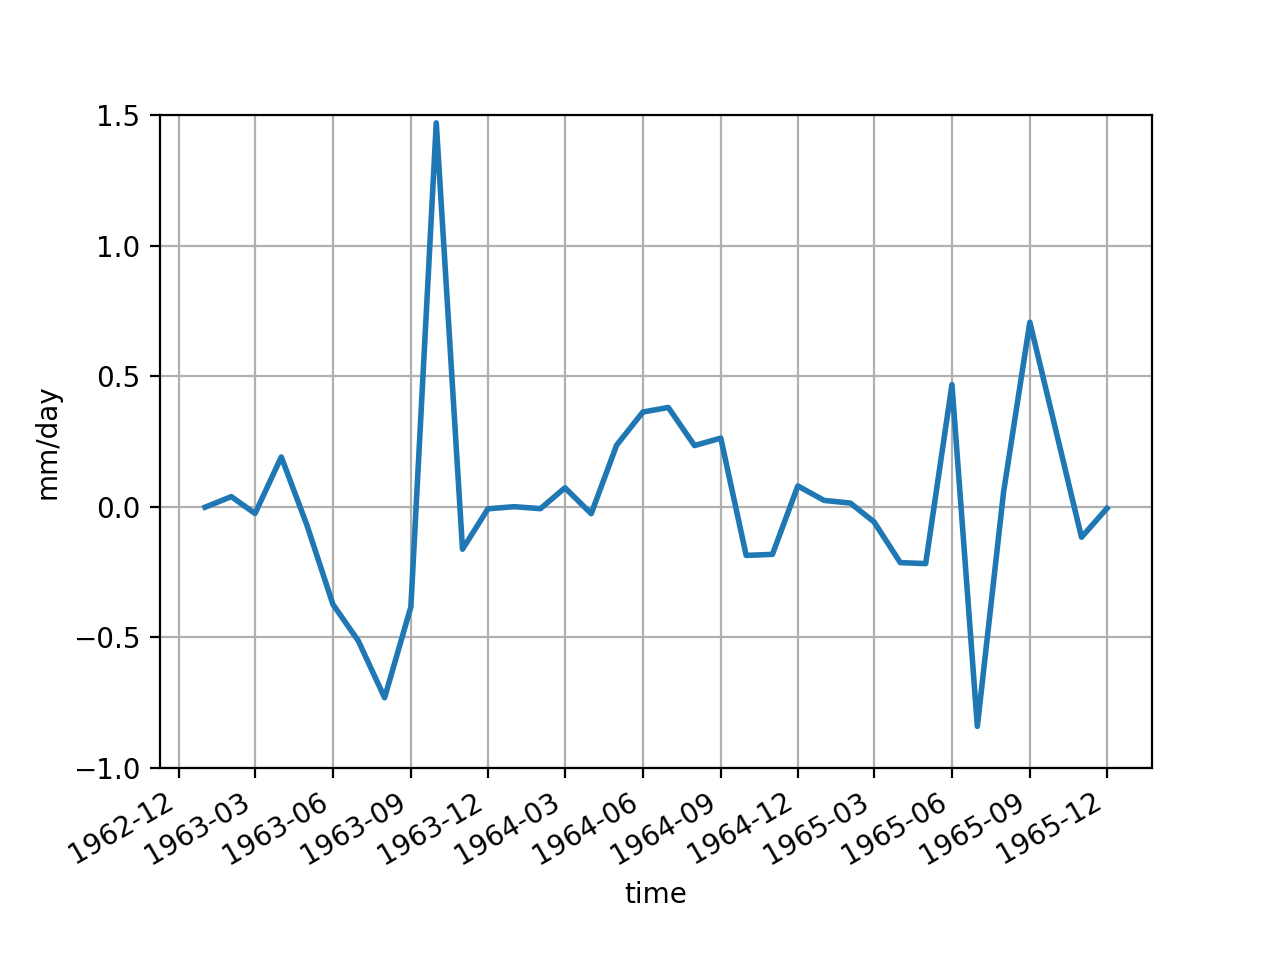

(-1, 1.5)

In [9]:
# Sahel rainfall time series
ts_ = ts.sel(time=years_after).groupby('time.month') \
    - ts.sel(time=years_before).groupby('time.month').mean('time') # anomaly
ts_.pipe(lambda x: x/30.).plot()
xticksmonth(range(3,13,3))
plt.grid(True)
plt.ylabel(units)
plt.ylim(-1,1.5)

### Zonal mean

In [24]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean # anomaly
# daa = daa.mean('lon')

In [12]:
# enso prcp
da_enso = get_enso_prcp(da, years=years_all)
damean = da_enso.sel(time=years_before).groupby('time.month').mean('time')
daa_enso = da_enso.sel(time=years_after).groupby('time.month') - damean # anomaly

<IPython.core.display.Javascript object>


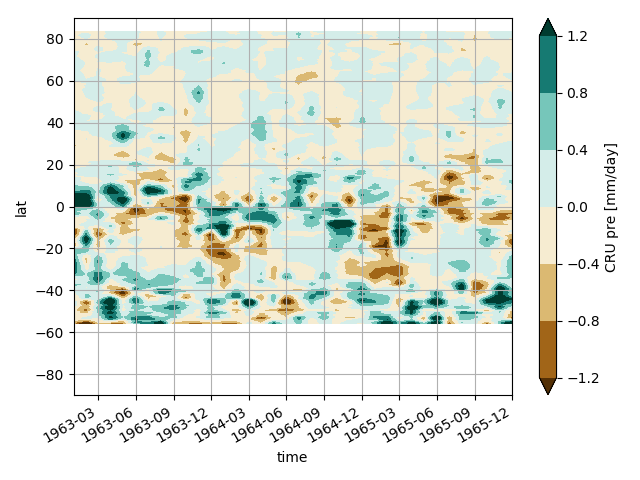

In [10]:
# all longitudes
daa.mean('lon').pipe(lambda x:x/30.).rename(f'CRU {data_name} [{units}]') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

<IPython.core.display.Javascript object>


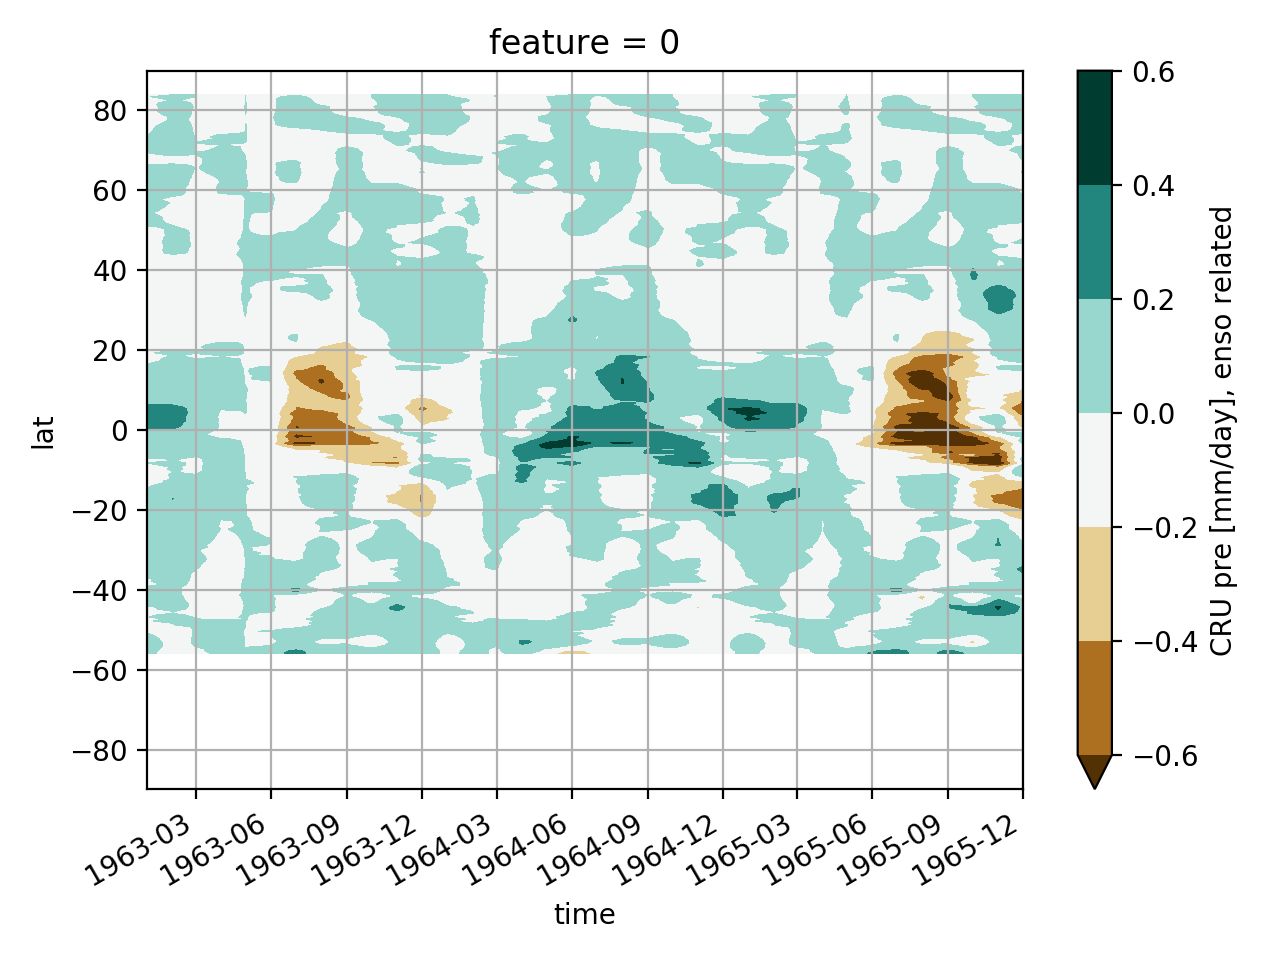

In [15]:
# all longitudes, enso related
daa_enso.mean('lon').pipe(lambda x:x/30.).rename(f'CRU {data_name} [{units}], enso related') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

<IPython.core.display.Javascript object>


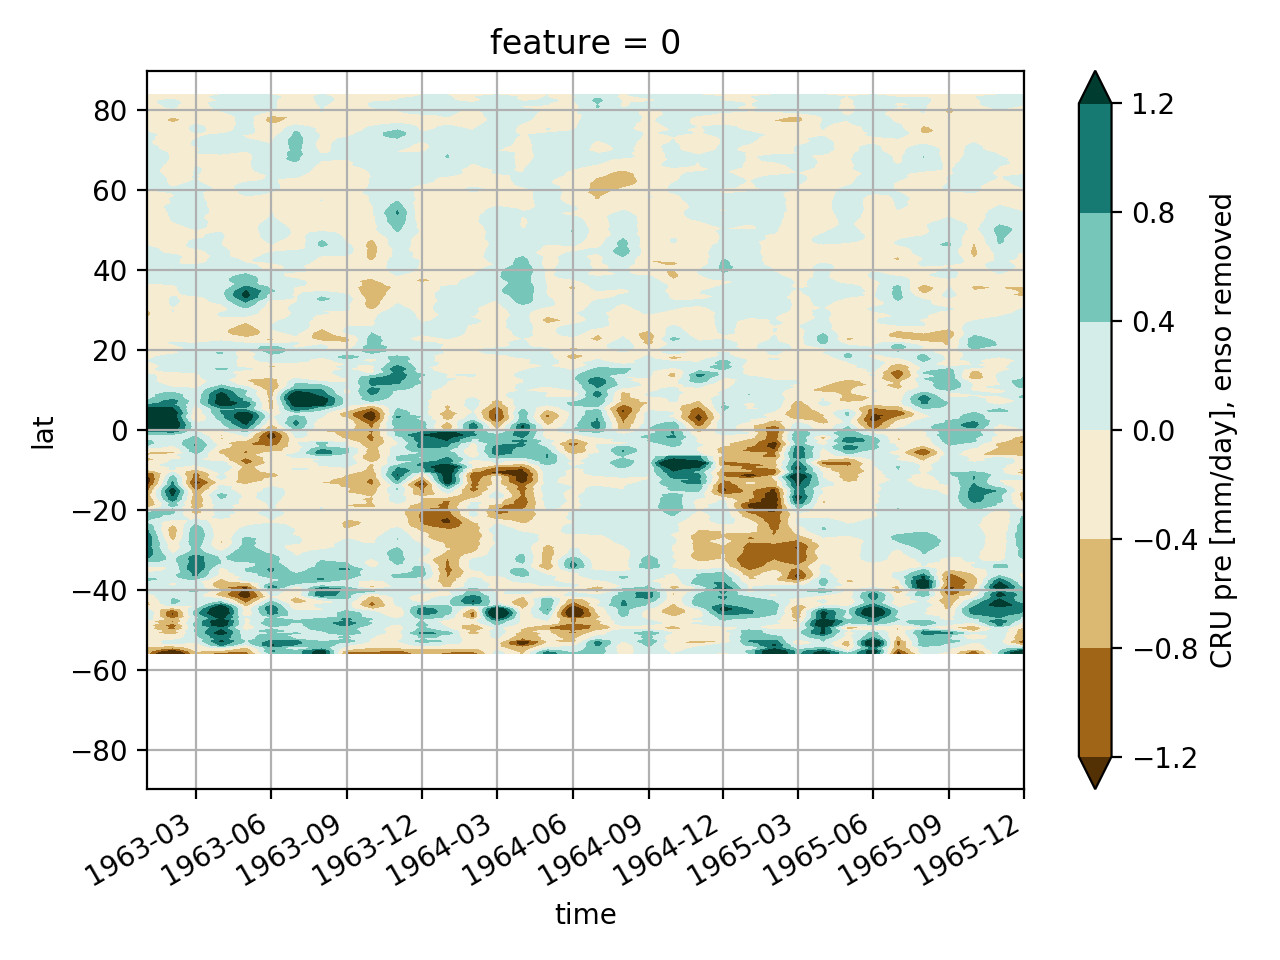

In [17]:
# all longitudes, enso removed
(daa - daa_enso).mean('lon').pipe(lambda x:x/30.).rename(f'CRU {data_name} [{units}], enso removed') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

<IPython.core.display.Javascript object>


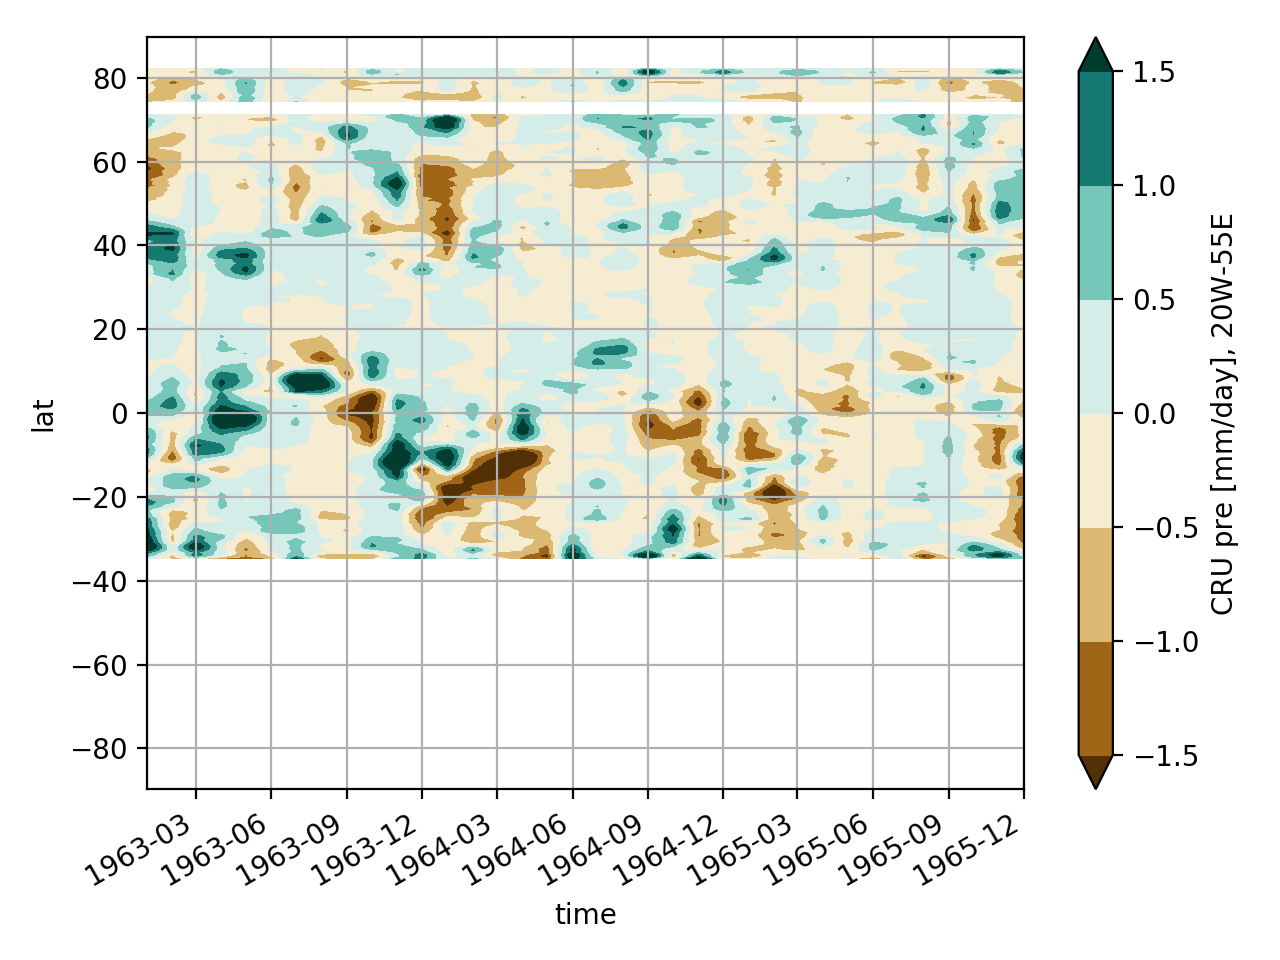

In [27]:
# longitudes: 20W-55E
daa.sel(lon=slice(-20,50)).mean('lon').pipe(lambda x:x/30.).rename(f'CRU {data_name} [{units}], 20W-55E') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

## Chichon 1982

In [34]:
year_erupt = 1982
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 2}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 2}')
units = 'mm/day'

### Seasonal mean

In [126]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1,None))

In [127]:
# enso prcp
da_enso = get_enso_prcp(da, years=years_all)
damean = da_enso.sel(time=years_before).groupby('time.month').mean('time')
daa_enso = da_enso.sel(time=years_after).groupby('time.month') - damean # anomaly
daa_enso = daa_enso.resample(time='QS-Dec').mean('time').isel(time=slice(1,None)) # seasonal meanb

<IPython.core.display.Javascript object>


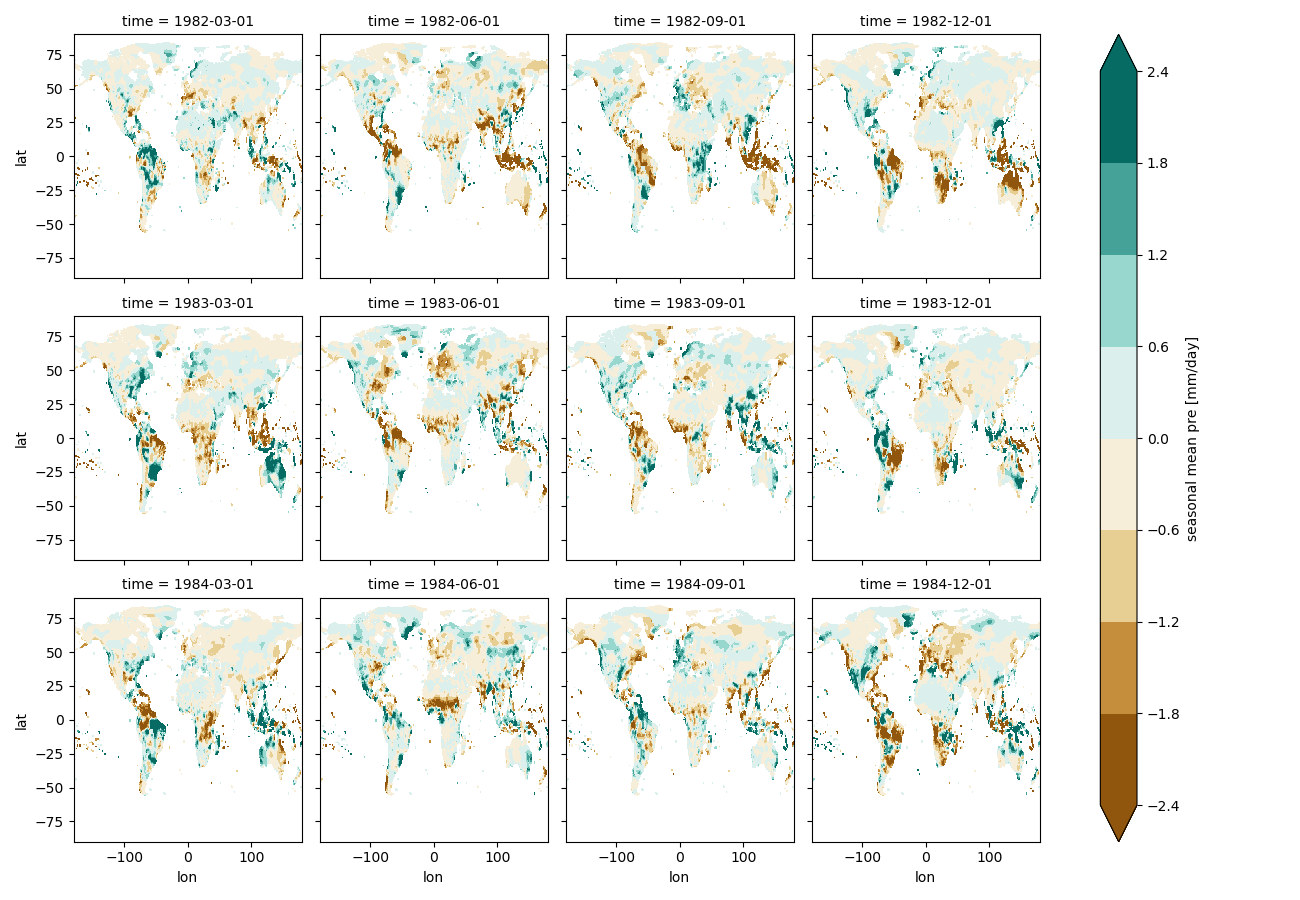

In [128]:
daa.pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


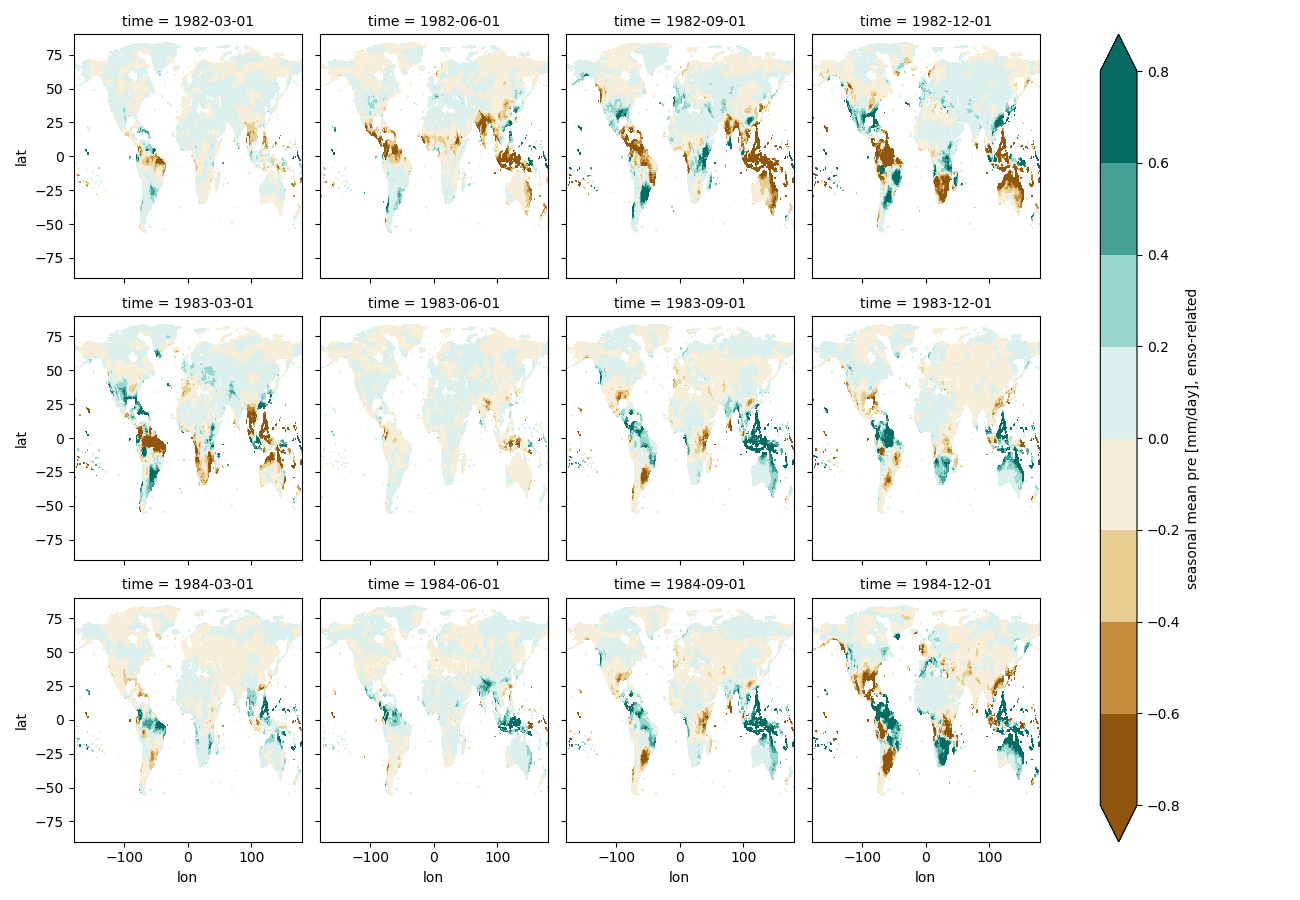

In [129]:
# enso prcp
daa_enso.pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}], enso-related')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


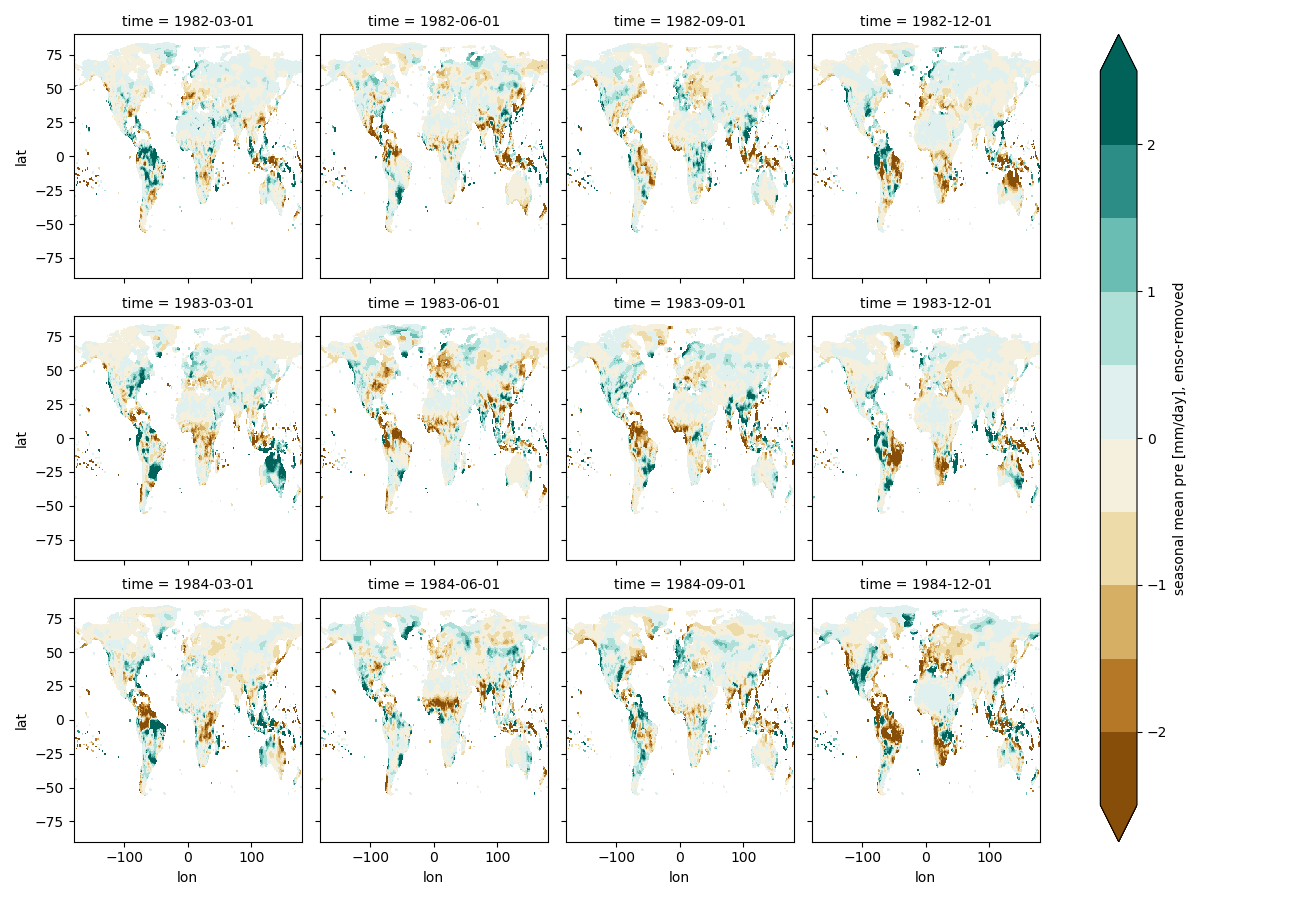

In [130]:
# enso removed
(daa - daa_enso).pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}], enso-removed')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


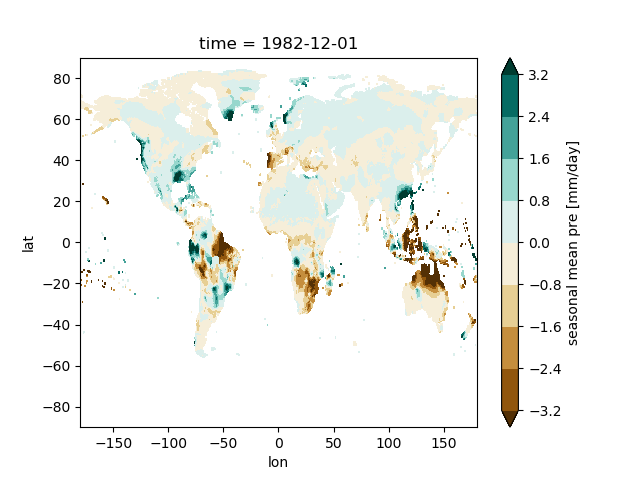

In [131]:
# following winter
daa.sel(time=f'{year_erupt}-12').pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


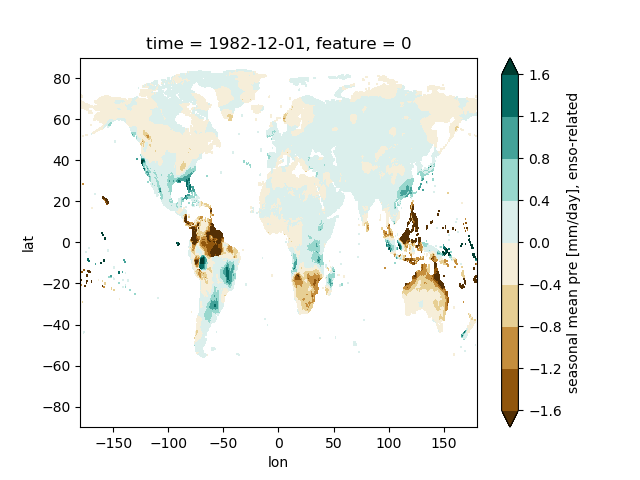

In [132]:
# following winter, enso-related
daa_enso.sel(time=f'{year_erupt}-12').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-related')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


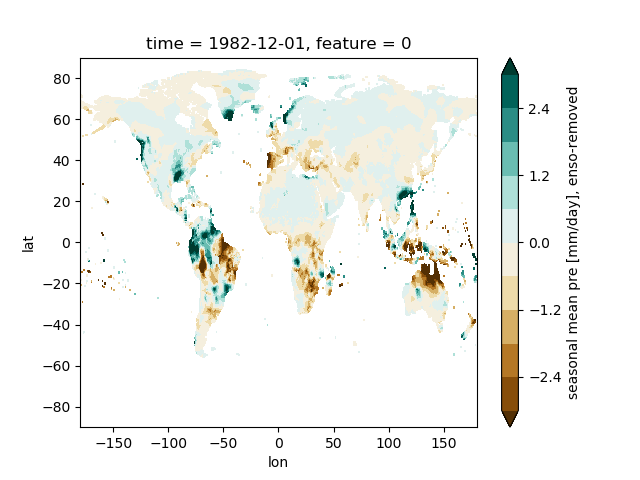

In [133]:
# following winter, enso-removed
(daa - daa_enso).sel(time=f'{year_erupt}-12').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-removed')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


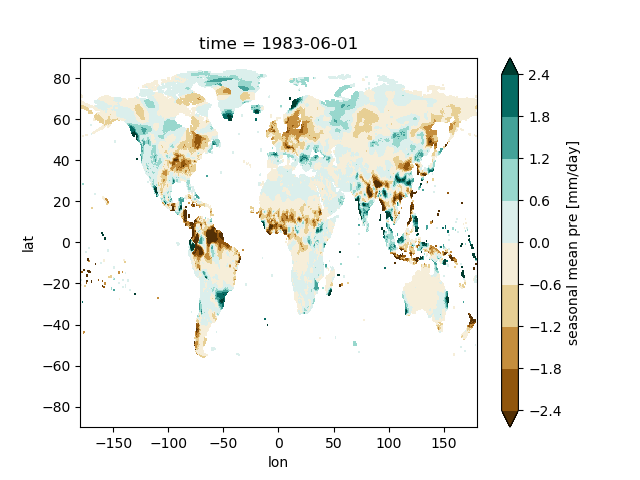

In [134]:
# next-year summer
daa.sel(time=f'{year_erupt+1}-06').pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


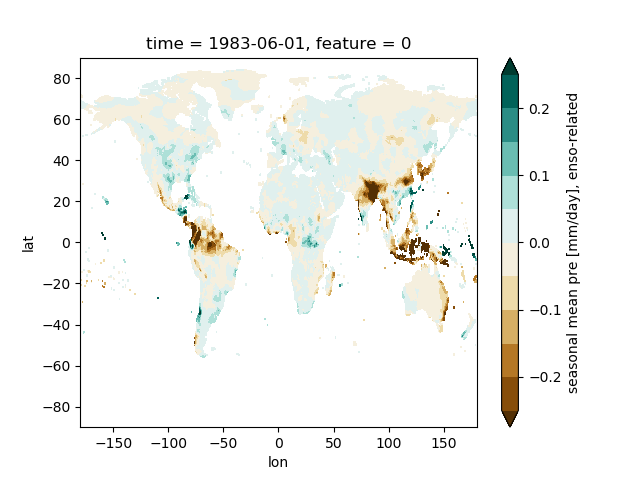

In [135]:
# next-year summer, enso-related
daa_enso.sel(time=f'{year_erupt+1}-06').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-related')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


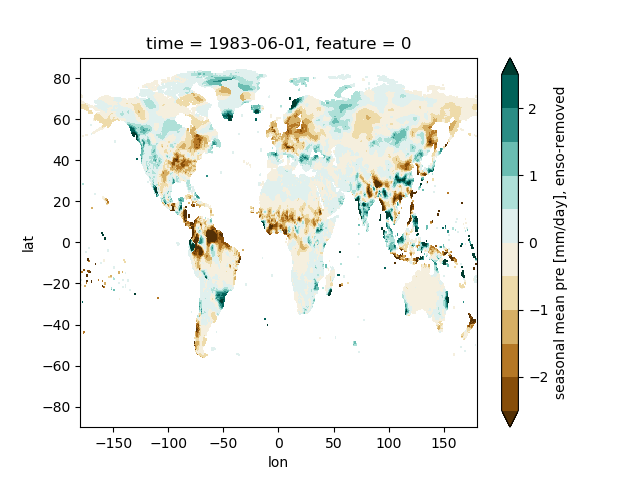

In [136]:
# next-year summer, enso-removed
(daa - daa_enso).sel(time=f'{year_erupt+1}-06').pipe(lambda x: x/30.0) \
    .rename(f'seasonal mean {data_name} [{units}], enso-removed')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


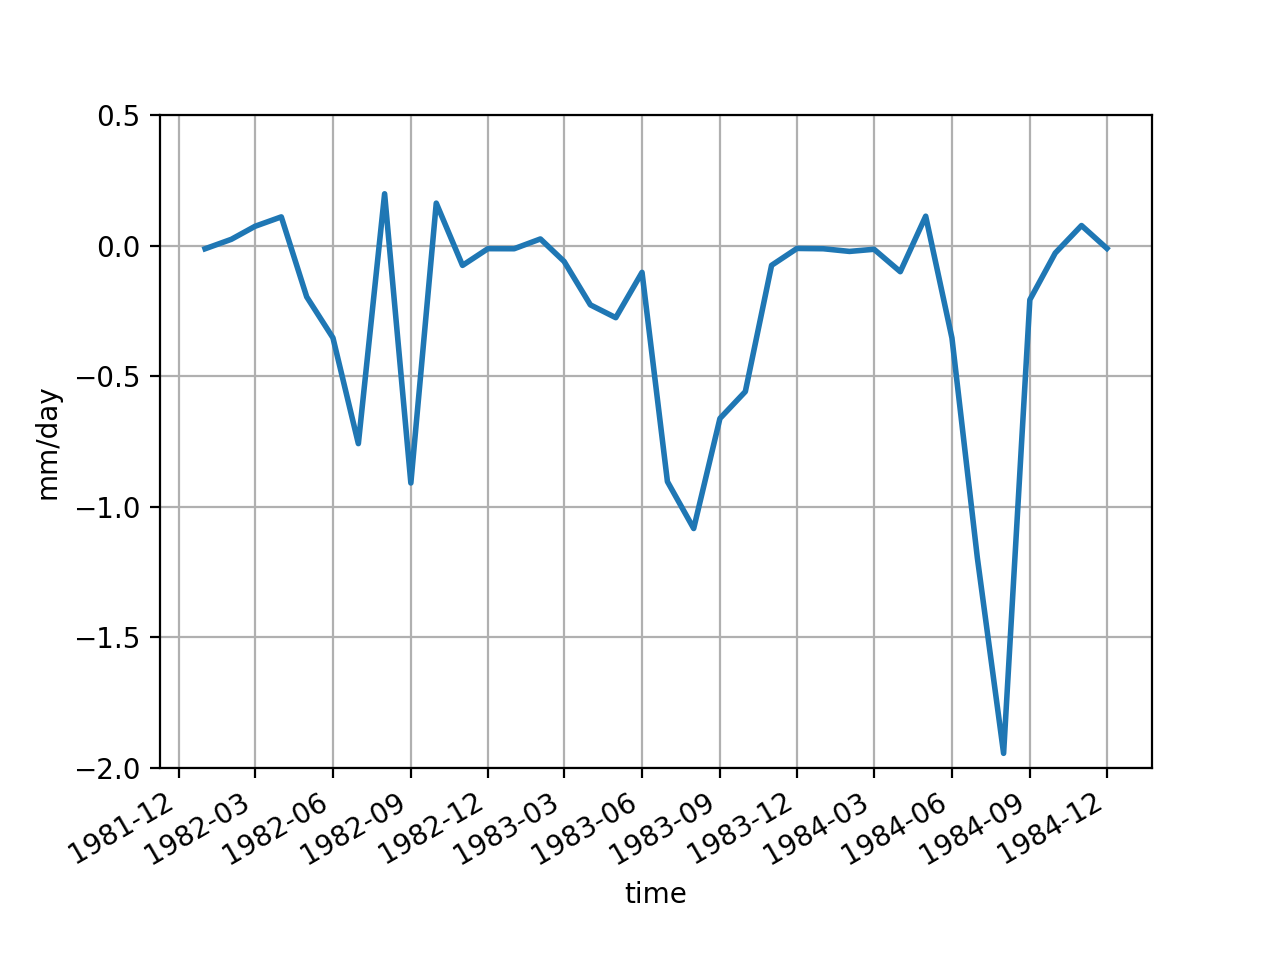

(-2, 0.5)

In [128]:
# Sahel rainfall time series
ts_ = ts.sel(time=years_after).groupby('time.month') \
    - ts.sel(time=years_before).groupby('time.month').mean('time') # anomaly
ts_.pipe(lambda x: x/30.).plot()
xticksmonth(range(3,13,3))
plt.grid(True)
plt.ylabel(units)
plt.ylim(-2,.5)

### Zonal mean

In [35]:
damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean # anomaly
# daa = daa.mean('lon')

<IPython.core.display.Javascript object>


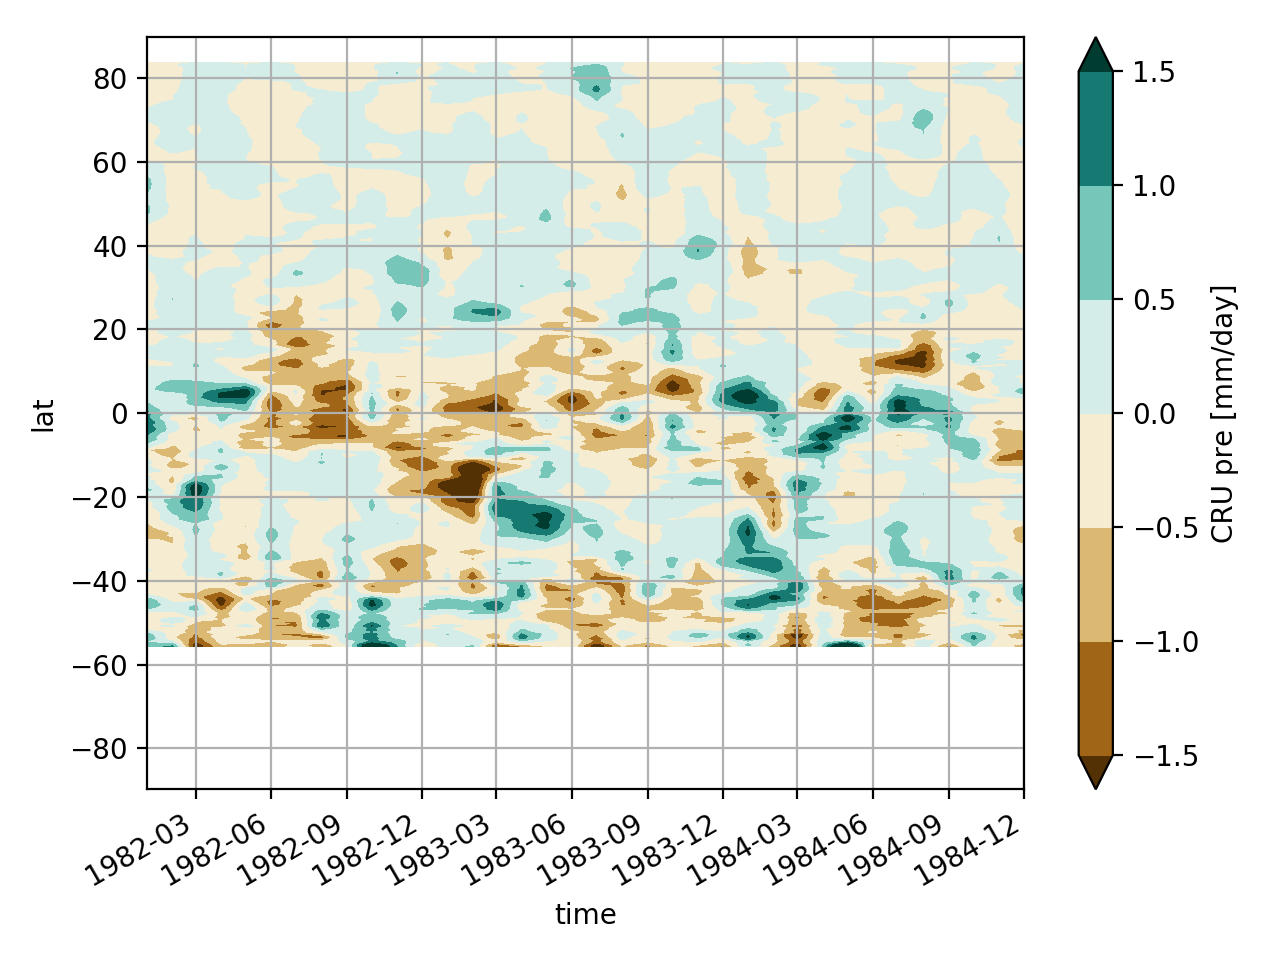

In [36]:
daa.mean('lon').pipe(lambda x:x/30.).rename(f'CRU {data_name} [{units}]') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

<IPython.core.display.Javascript object>


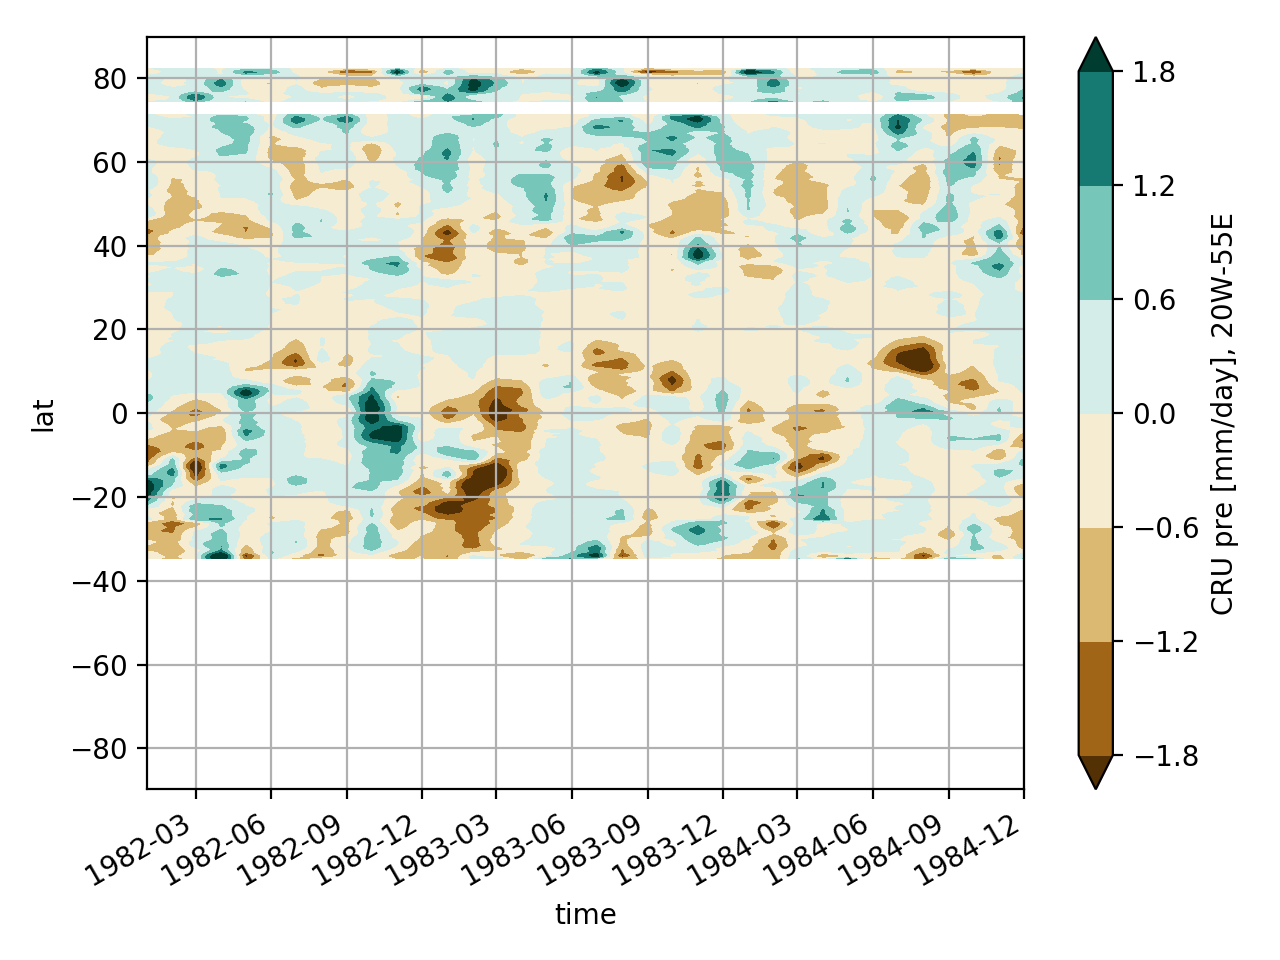

In [37]:
# longitudes: 20W-55E
daa.sel(lon=slice(-20,50)).mean('lon').pipe(lambda x:x/30.).rename(f'CRU {data_name} [{units}], 20W-55E') \
    .plot.contourf(x='time', y='lat', robust=True, cmap='BrBG')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.tight_layout()

## Pinatubo 1991

In [11]:
year_erupt = 1991
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 2}')
units = 'mm/day'

damean = da.sel(time=years_before).groupby('time.month').mean('time')
daa = da.sel(time=years_after).groupby('time.month') - damean
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1,None))
das['pre.anom.pinatubo'] = daa

<IPython.core.display.Javascript object>


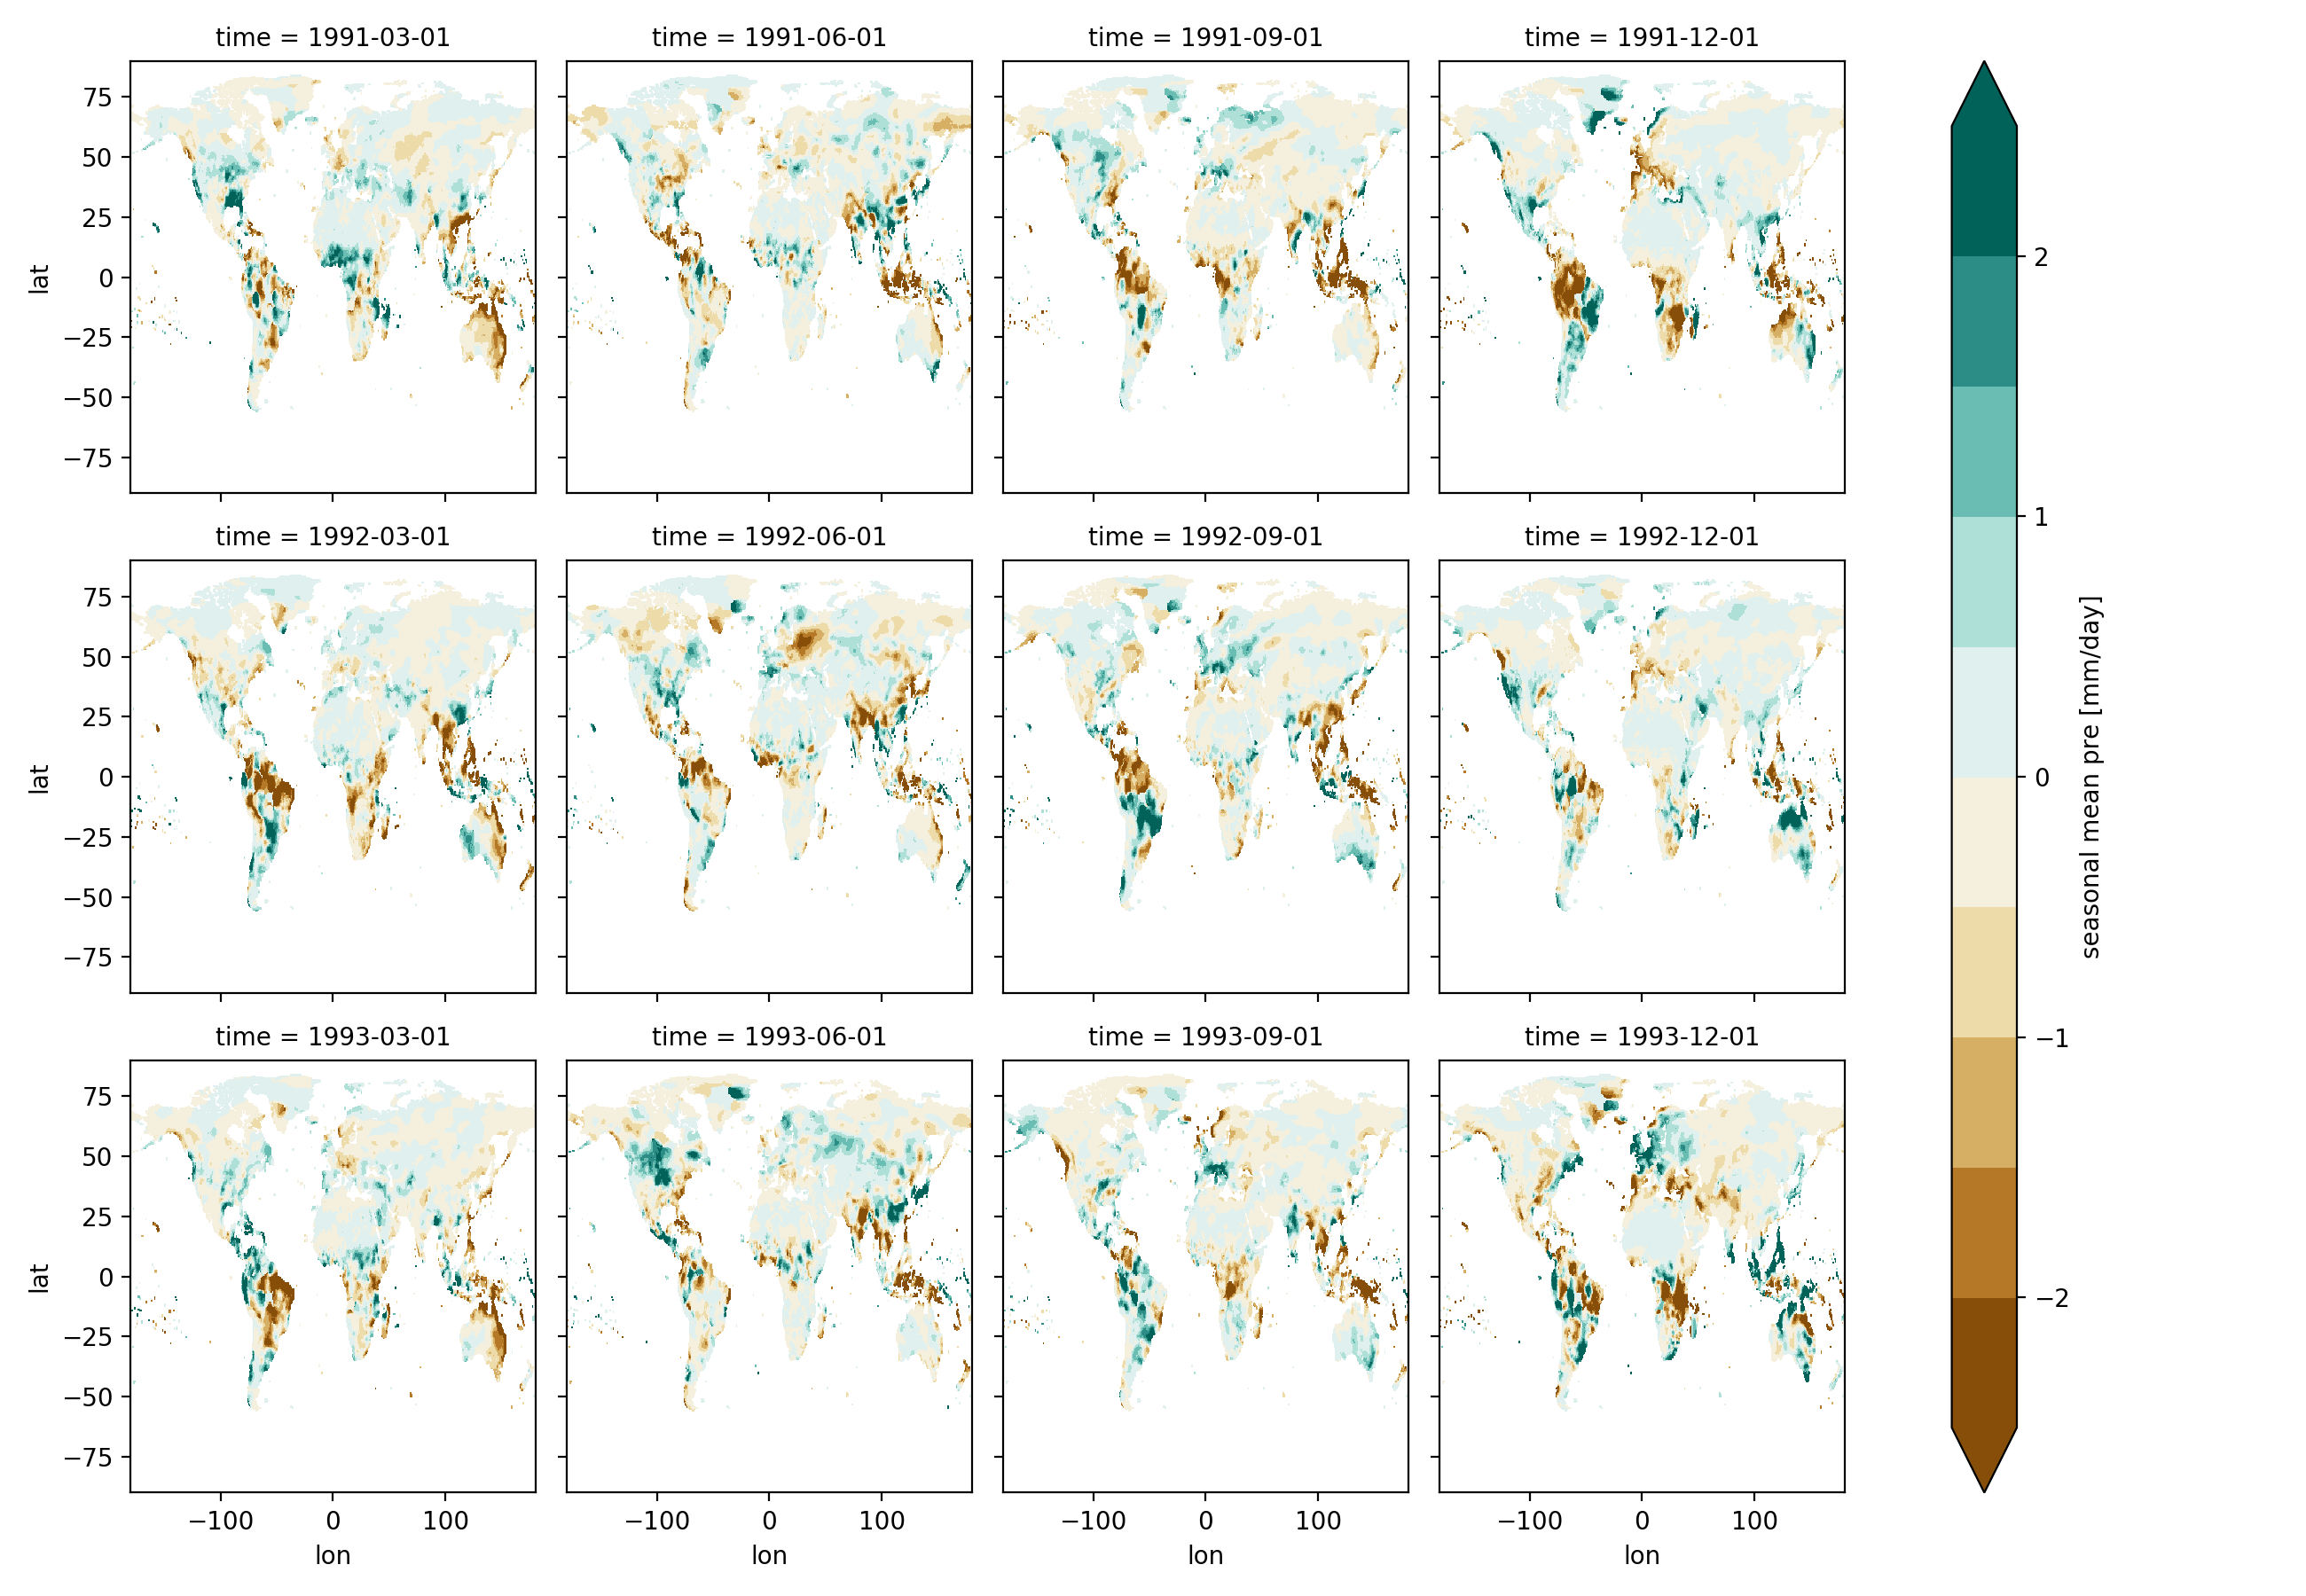

In [119]:
daa.pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


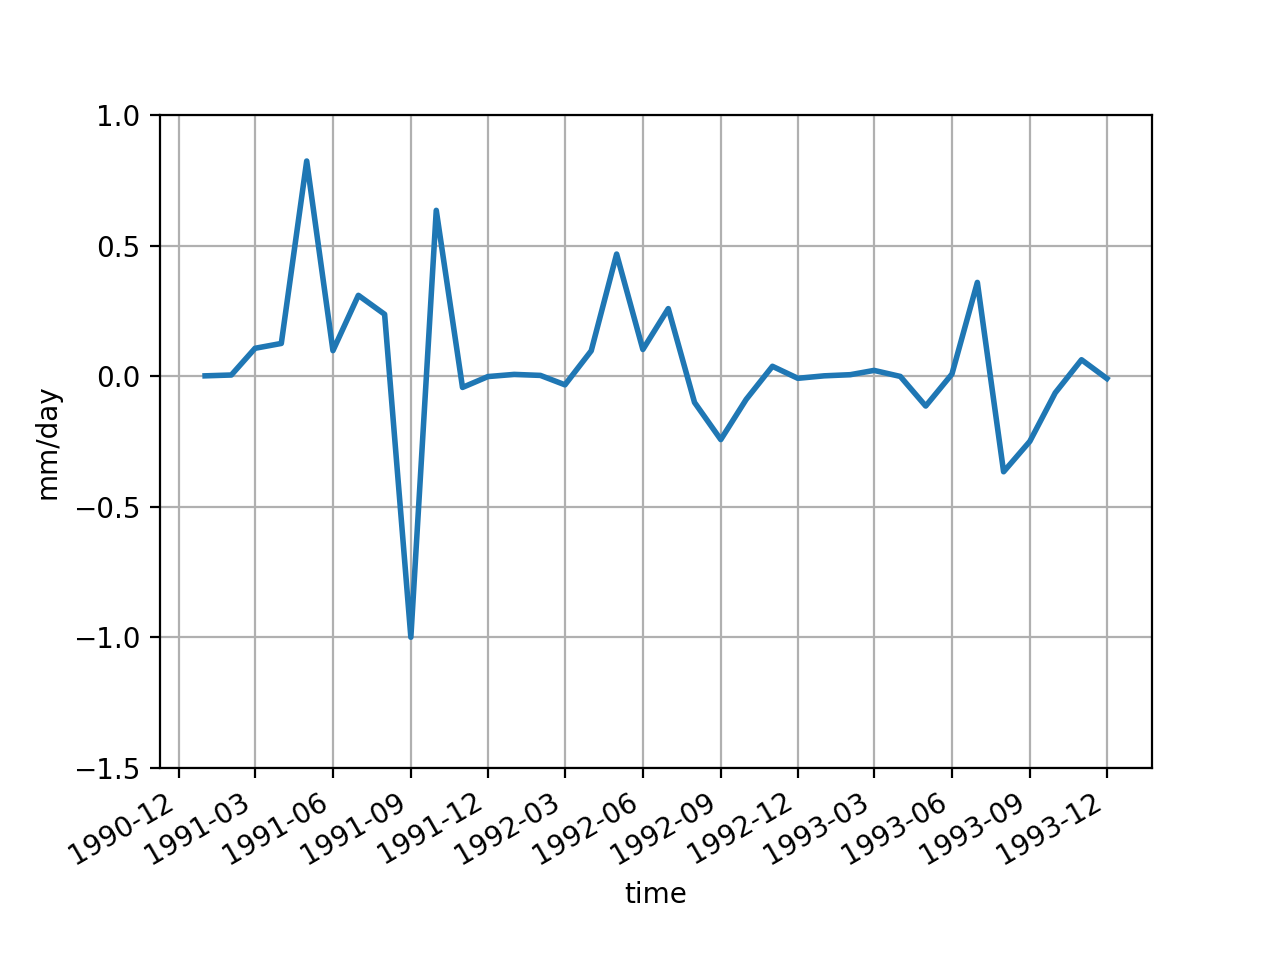

(-1.5, 1)

In [13]:
# Sahel rainfall time series
ts_ = ts.sel(time=years_after).groupby('time.month') \
    - ts.sel(time=years_before).groupby('time.month').mean('time') # anomaly
ts_.pipe(lambda x: x/30.).plot()
xticksmonth(range(3,13,3))
plt.grid(True)
plt.ylabel(units)
plt.ylim(-1.5,1)

## ENSO removed

In [31]:
nino = nino34 \
    .rename({'T': 'time'}) \
    .resample(time='MS').mean('time')
nino1901_2016 = nino.sel(time=slice('1901', '2016'))
r = da.learn.regress(nino1901_2016)
da_res = da - r.coef_da * nino1901_2016

//home/wenchang/wython/xlearn/linear_model.py:129: RuntimeWarning: divide by zero encountered in true_divide
  t = self.coef_ / se
//home/wenchang/wython/xlearn/linear_model.py:129: RuntimeWarning: invalid value encountered in true_divide
  t = self.coef_ / se
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [32]:
# raw data
year_erupt = 1963
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [33]:
damean = da_res.sel(time=years_before).groupby('time.month').mean('time')
daa = da_res.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(-2.090724)
Coordinates:
    feature  int64 0

In [34]:
# raw data
year_erupt = 1991
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [35]:
damean = da_res.sel(time=years_before).groupby('time.month').mean('time')
daa = da_res.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(-6.073141)
Coordinates:
    feature  int64 0

In [36]:
# raw data
year_erupt = 1982
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [37]:
damean = da_res.sel(time=years_before).groupby('time.month').mean('time')
daa = da_res.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(0.209643)
Coordinates:
    feature  int64 0

In [38]:
# raw data
year_erupt = 1902
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 4}')
years_all = slice(f'{year_erupt -5}', f'{year_erupt + 4}')
units = 'mm/day'

In [39]:
damean = da_res.sel(time=years_before).groupby('time.month').mean('time')
daa = da_res.sel(time=years_after).groupby('time.month') - damean # anomaly
da_nh = daa.sel(lat=slice(0, 90)).geo.fldmean().mean('time')
da_sh = daa.sel(lat=slice(-90,0)).geo.fldmean().mean('time')
da_global = daa.geo.fldmean().mean('time')
(da_nh - da_sh)/da_global

<xarray.DataArray ()>
array(2.606234)
Coordinates:
    feature  int64 0

In [72]:
#  ENSO removed
year_erupt = 1963
years_before = slice(f'{year_erupt - 5}', f'{year_erupt - 1}')
years_after = slice(f'{year_erupt}', f'{year_erupt + 2}')
units = 'mm/day'

damean = da_res.sel(time=years_before).groupby('time.month').mean('time')
daa = da_res.sel(time=years_after).groupby('time.month') - damean # anomaly
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1,None)) # seasonal mean
das['pre.anom.res.agung'] = daa

<IPython.core.display.Javascript object>


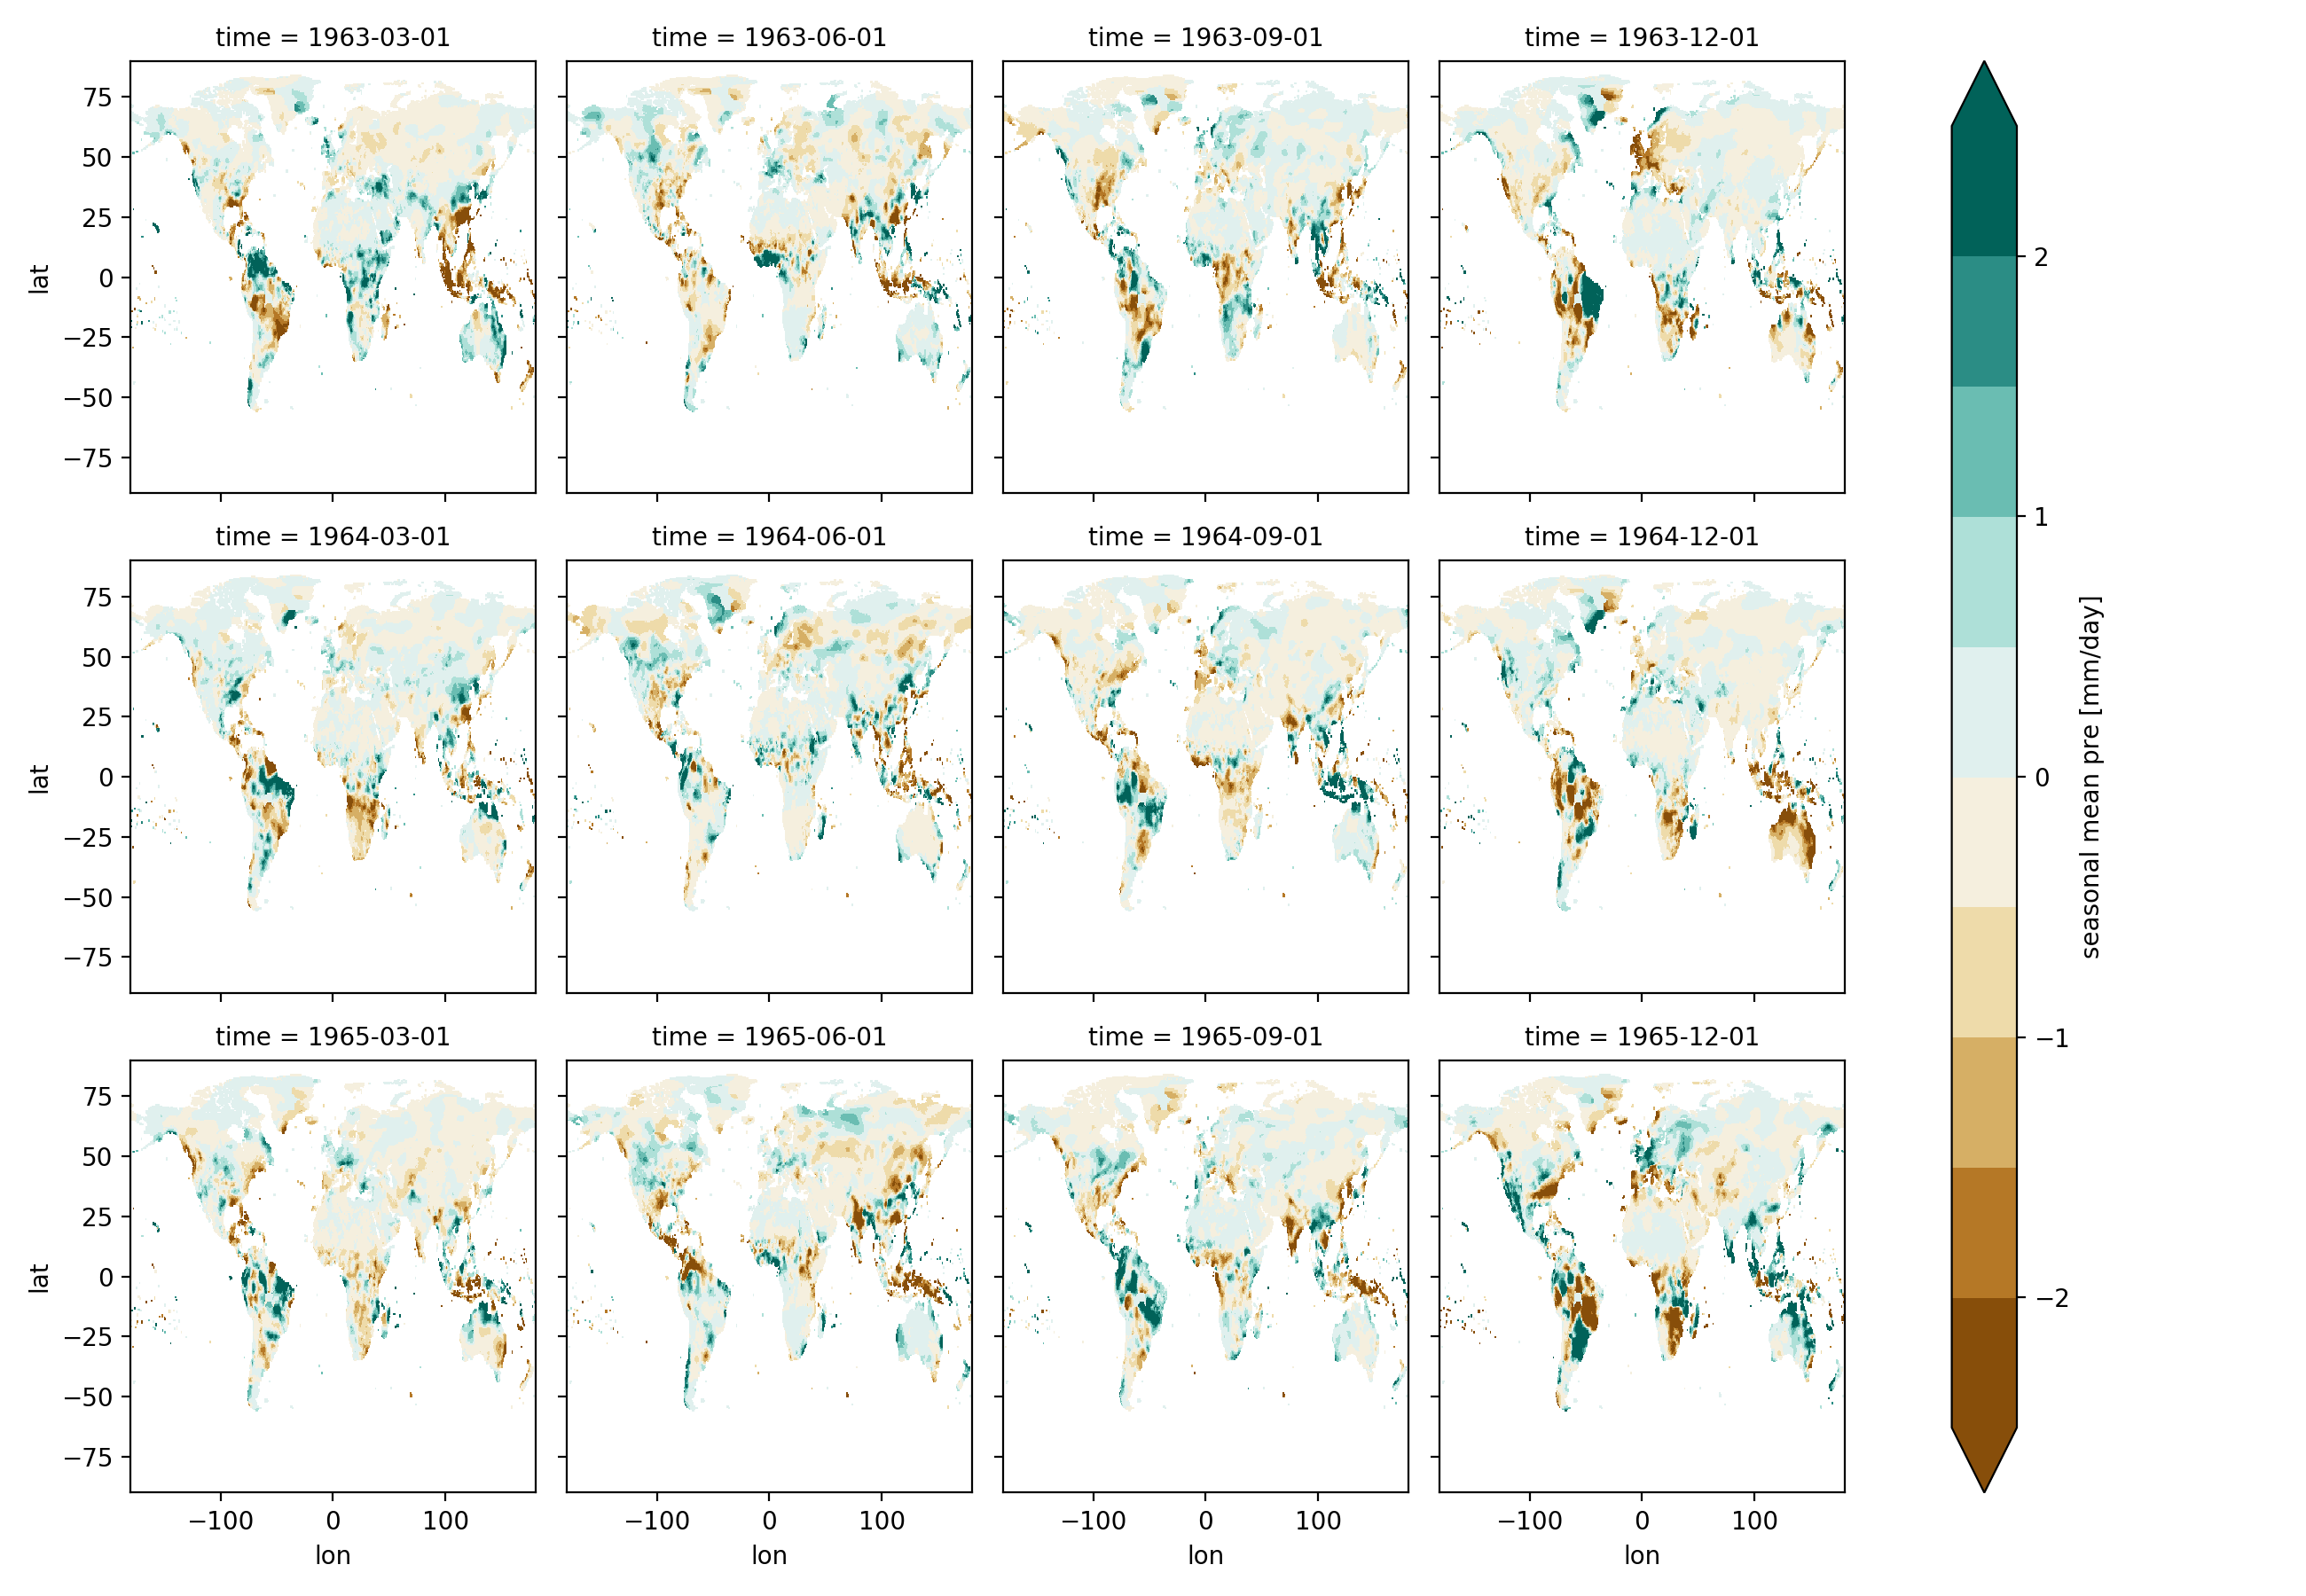

In [63]:
daa.pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(col='time', col_wrap=4, robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


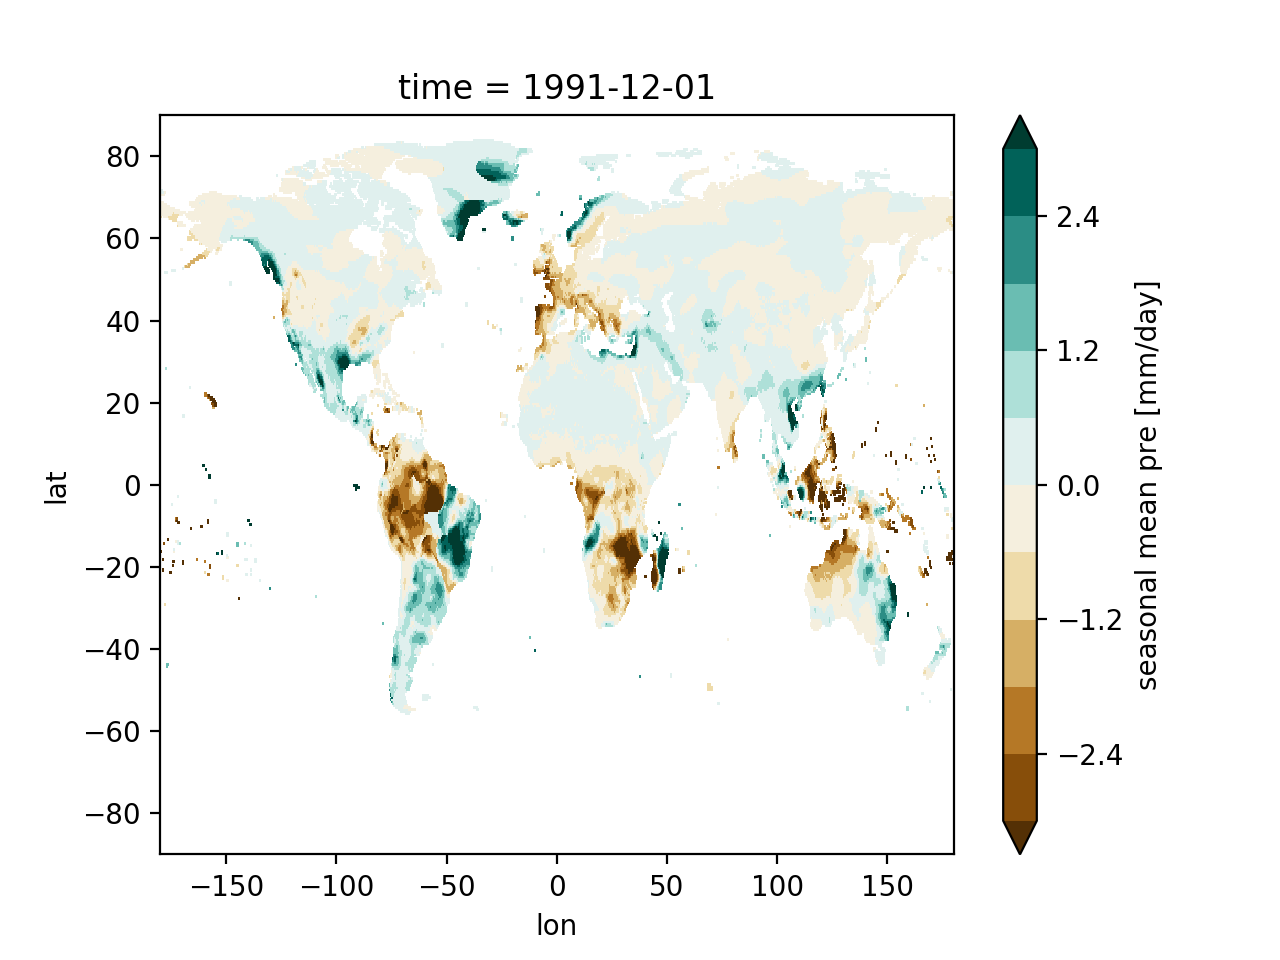

In [120]:
# following winter
daa.sel(time=f'{year_erupt}-12').pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


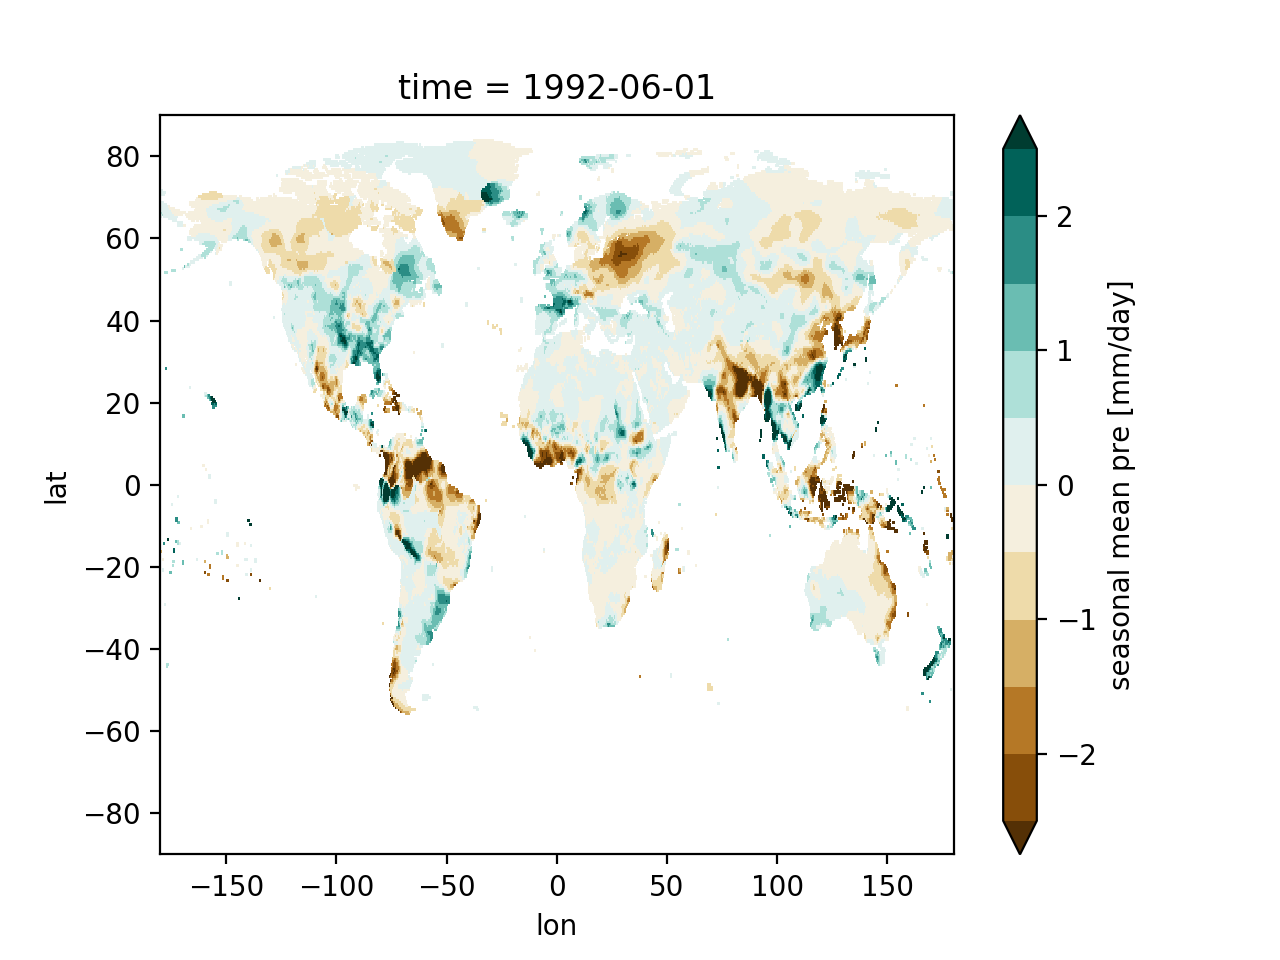

In [121]:
# next-year summer
daa.sel(time=f'{year_erupt+1}-06').pipe(lambda x: x/30.0).rename(f'seasonal mean {data_name} [{units}]')\
    .plot(robust=True, levels=10, cmap='BrBG')

<IPython.core.display.Javascript object>


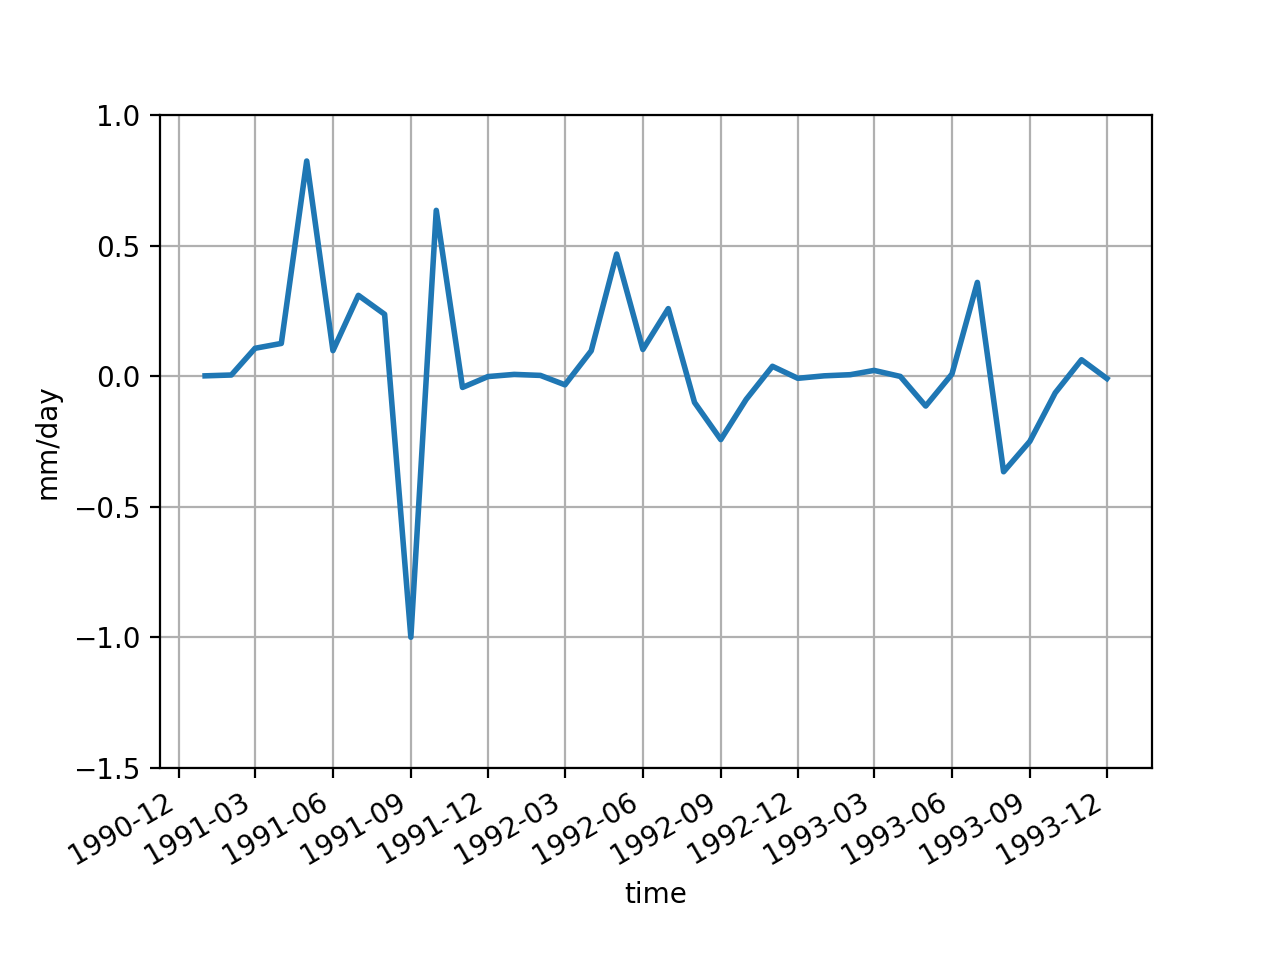

(-1.5, 1)

In [123]:
# Sahel rainfall time series
ts_ = ts.sel(time=years_after).groupby('time.month') \
    - ts.sel(time=years_before).groupby('time.month').mean('time') # anomaly
ts_.pipe(lambda x: x/30.).plot()
xticksmonth(range(3,13,3))
plt.grid(True)
plt.ylabel(units)
plt.ylim(-1.5, 1)